# Libraries

In [1]:
import math
import pandas as pd
import numpy as np
import inflection 
import seaborn as sns
import pylab
import xgboost as xgb
 
from matplotlib import pyplot as plt
from IPython.display import Image
from datetime import datetime
from datetime import timedelta
import matplotlib.gridspec as gridspec
from tabulate import tabulate
from scipy import stats as ss

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error 
from sklearn.linear_model import LinearRegression, Lasso

### Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

### Loading Data

Firstly, we are going to check all datasets out. We must verify what kind of fields there are in every dataset. 

In [3]:
data_raw_train = pd.read_csv("datasets/train.csv", low_memory=False)
data_raw_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
data_raw_test = pd.read_csv("datasets/test.csv", low_memory=False)
data_raw_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [5]:
data_raw_store = pd.read_csv("datasets/store.csv", low_memory=False)
data_raw_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
data_raw_sample = pd.read_csv("datasets/sample_submission.csv", low_memory=False)
data_raw_sample.head()

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


Based on the data above, we are going to merge the datasets "train" and "store". They are the ones with the relevant data we need to perform the forecast. 

In [7]:
data_raw = pd.merge(data_raw_train, data_raw_store, how="left", on="Store")
data_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1. Data Description

In [8]:
df1 = data_raw.copy()

#### Data fields meaning

**- Id:** an Id that represents a (Store, Date) duple within the test set.

**- Store:** a unique Id for each store.

**- Sales:** the turnover for any given day (this is what you are predicting).

**- Customers:** the number of customers on a given day.

**- Open:** an indicator for whether the store was open: 0 = closed, 1 = open.

**- StateHoliday:** indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None.

**- SchoolHoliday:** indicates if the (Store, Date) was affected by the closure of public schools.

**- StoreType:** differentiates between 4 different store models: a, b, c, d.

**- Assortment:** describes an assortment level: a = basic, b = extra, c = extended.

**- CompetitionDistance:** distance in meters to the nearest competitor store.

**- CompetitionOpenSince[Month/Year]:** gives the approximate year and month of the time the nearest competitor was opened.

**- Promo:** indicates whether a store is running a promo on that day.

**- Promo2:** Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating.

**- Promo2Since[Year/Week]:** describes the year and calendar week when the store started participating in Promo2.

**- PromoInterval:** describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.

## 1.1. Rename Columns

We are going to rename columns from camel case to snake case.

In [9]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case, cols_old))

#rename
df1.columns = cols_new

In [11]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [12]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3. Data Types

In [13]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [14]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
221972,88,2,2015-01-13,7855,803,1,1,0,0,a,a,10690.0,10.0,2005.0,0,NaN,NaN,NaN


In [15]:
df1["state_holiday"].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [16]:
df1["date"] = pd.to_datetime( df1["date"] )

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA/Missing values

In [18]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [19]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA/Missing values

We have 03 different types of treating NA values:

**1.** Deleting all of them. It is easy and fast, but it results in a big loss. 

**2.** We may also use Machine Learning algorithms to fill them based on the column characteristics. e.g.: using median, mean or even clustering. 

**3.** We can fill them based on business decisions. That's the one we are going to use for now.   

#### competition_distance

This column means the "distance in meters to the nearest competitor store". We may assume that NA values are the ones greater than the maximum distance between the stores. 

In [20]:
df1["competition_distance"].max()

75860.0

As the maximum distance between competitors store is 75860.0 m, we may replace NA values with 200000.0. This replacement means, in other words, that the store has no competitor - based on the competition_distance field.  

In [21]:
df1["competition_distance"] = df1["competition_distance"].apply(lambda x: 200000.0 if math.isnan(x) else x)

#### competition_open_since_month

This field gives the approximate month of the time the nearest competitor was opened. We are going to use the month from the date field where there are NA values in the column competition_since_open_month. 

In [22]:
df1["competition_open_since_month"].min()

1.0

In [23]:
df1["competition_open_since_month"].unique()

array([ 9., 11., 12.,  4., 10.,  8., nan,  3.,  6.,  5.,  1.,  2.,  7.])

We are going to replace NA values with the month of the date of the row. 

In [24]:
df1["competition_open_since_month"] = df1.apply(lambda x: 
                                                x["date"].month if math.isnan(x["competition_open_since_month"]) 
                                                else x["competition_open_since_month"], axis=1)

#### competition_open_since_year

The procedure is very similar to the last treatment. However, we are going to use year instead of month. 

In [25]:
df1["competition_open_since_year"].unique()

array([2008., 2007., 2006., 2009., 2015., 2013., 2014., 2000., 2011.,
         nan, 2010., 2005., 1999., 2003., 2012., 2004., 2002., 1961.,
       1995., 2001., 1990., 1994., 1900., 1998.])

We are going to replace NA values with the month of the date of the row.

In [26]:
df1["competition_open_since_year"] = df1.apply(lambda x: 
                                                x["date"].year if math.isnan(x["competition_open_since_year"]) 
                                                else x["competition_open_since_year"], axis=1)

#### promo2_since_week

Promo2 is a continuing and consecutive promotion for some stores. promo2_since_week describes the week when the store started participating in Promo2. The treatment is similar to the last one above, yet using week as time period. 

In [27]:
df1["promo2_since_week"] = df1.apply(lambda x: 
                                    x["date"].week if math.isnan(x["promo2_since_week"]) 
                                    else x["promo2_since_week"], axis=1)

In [28]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week                    0
promo2_since_year               508031
promo_interval                  508031
dtype: int64

#### promo2_since_year

Similar to the treatment above. Yet, using year as time period. 

In [29]:
df1["promo2_since_year"] = df1.apply(lambda x: 
                                    x["date"].year if math.isnan(x["promo2_since_year"]) 
                                    else x["promo2_since_year"], axis=1)

In [30]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week                    0
promo2_since_year                    0
promo_interval                  508031
dtype: int64

#### promo_interval

This field describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.

For this treatment, we created a new column named "is_promo" where: 

1. 0 means there is no promo2 because promo_interval is 0 (previous NA).
2. 1 if the month from date field is in promo_interval field. 

In [31]:
month_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec", }

df1["promo_interval"].fillna(0, inplace=True)

df1["month_map"] = df1["date"].dt.month.map(month_map) 

df1["is_promo"] = df1[["promo_interval", "month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 
                                                              else 1 if x["month_map"] in x["promo_interval"].split(",") else 0, axis=1)

In [32]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
52617,213,7,2015-06-14,0,0,0,0,0,0,d,c,4030.0,3.0,2014.0,1,1.0,2014.0,"Jan,Apr,Jul,Oct",Jun,0
475069,865,5,2014-05-02,11455,896,1,1,0,0,d,c,2640.0,5.0,2014.0,0,18.0,2014.0,0,May,0
81768,374,2,2015-05-19,9020,995,1,1,0,0,a,a,1150.0,9.0,2007.0,0,21.0,2015.0,0,May,0
235126,977,5,2015-01-02,3320,400,1,0,0,1,a,a,520.0,9.0,2005.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jan,1
881298,119,4,2013-05-02,7592,838,1,1,0,0,a,c,2100.0,2.0,2010.0,0,18.0,2013.0,0,May,0


In [33]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

Since we did many operations with the columns in the last section, it is quite important to check their types and change them if necessary. 

In [34]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [35]:
df1.sample(3)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
601435,121,3,2014-01-08,5328,549,1,1,0,0,a,a,3570.0,11.0,2009.0,1,36.0,2013.0,"Mar,Jun,Sept,Dec",Jan,0
895761,87,5,2013-04-19,4699,678,1,0,0,0,a,a,560.0,12.0,2010.0,0,16.0,2013.0,0,Apr,0
543950,616,6,2014-03-01,7278,722,1,0,0,0,a,c,3040.0,8.0,2011.0,1,35.0,2010.0,"Mar,Jun,Sept,Dec",Mar,1


In [36]:
df1["sales"] = df1["sales"].astype(float)
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)
df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

In [37]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                  float64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [38]:
df1.sample(3)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
195174,50,5,2015-02-06,4933.0,404,1,1,0,0,d,a,6260.0,11,2009,0,6,2015,0,Feb,0
612004,655,1,2013-12-30,8785.0,828,1,0,0,1,d,c,960.0,11,2012,1,5,2013,"Feb,May,Aug,Nov",Dec,0
338018,791,7,2014-09-14,0.0,0,0,0,0,0,a,a,5950.0,4,2007,0,37,2014,0,Sep,0


## 1.7 Descriptive Statistics

This section is necessary to know better our business and also to identify tendencies, problems or anomalies in our dataset. 

Firstly, let's separate the data into numerical and categorical attributes:

In [39]:
num_attributes = df1.select_dtypes(include=["int64", "float64"])
cat_attributes = df1.select_dtypes(exclude=["int64", "float64", "datetime64[ns]"])

In [40]:
num_attributes.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo'],
      dtype='object')

In [41]:
cat_attributes.columns

Index(['state_holiday', 'store_type', 'assortment', 'promo_interval',
       'month_map'],
      dtype='object')

### 1.7.1. Numerical attributes

In this section, we are goint to work with two types of metrics:

1. Central tendency metrics: mean and median.
2. Dispersion metrics: standard deviation, minimum, maximum, range, skewness, and kurtosis. 

In [42]:
# Central tendency metrics
c1 = pd.DataFrame(num_attributes.apply( np.mean )).T
c2 = pd.DataFrame(num_attributes.apply( np.median )).T

# Dispersion metrics
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.min() )).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() )).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# Concatenate metric
m = pd.concat([d2, d3, d4, c1, c2, d1, d5, d6]).T.reset_index()
m.columns = ["attributes", "min", "max", "range", "mean", "median", "std", "skewness", "kurtosis"]

In [43]:
m

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


**Skewness:** how much a distribution of data deviates from a normal distribution.

1. Median greater than mean: right or negative skewness (mean minus median).
2. Median less than mean: left or positive skewness (mean minus median).
3. The median will always be in the direction of the highest concentration.
4. Median equals mean: normal distribution = no skewness.

ML algorithms need to train with unbiased data, that is, the distribution of the response variable (target) needs to be closer to a normal distribution.

Based on metrics above, we may see that mean is very close to the median. In some cases, they are so close to each other (according to the range) that two first rules does not match. However, it is good result because that means the distribution is very similar to a normal one and the Machine Learning model will not deal with a biased dataset.  

**Kurtosis:** data distribution around the mean and the existence of long tails. High kurtosis: concentration around the mean. A high kurtosis can bias the model.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

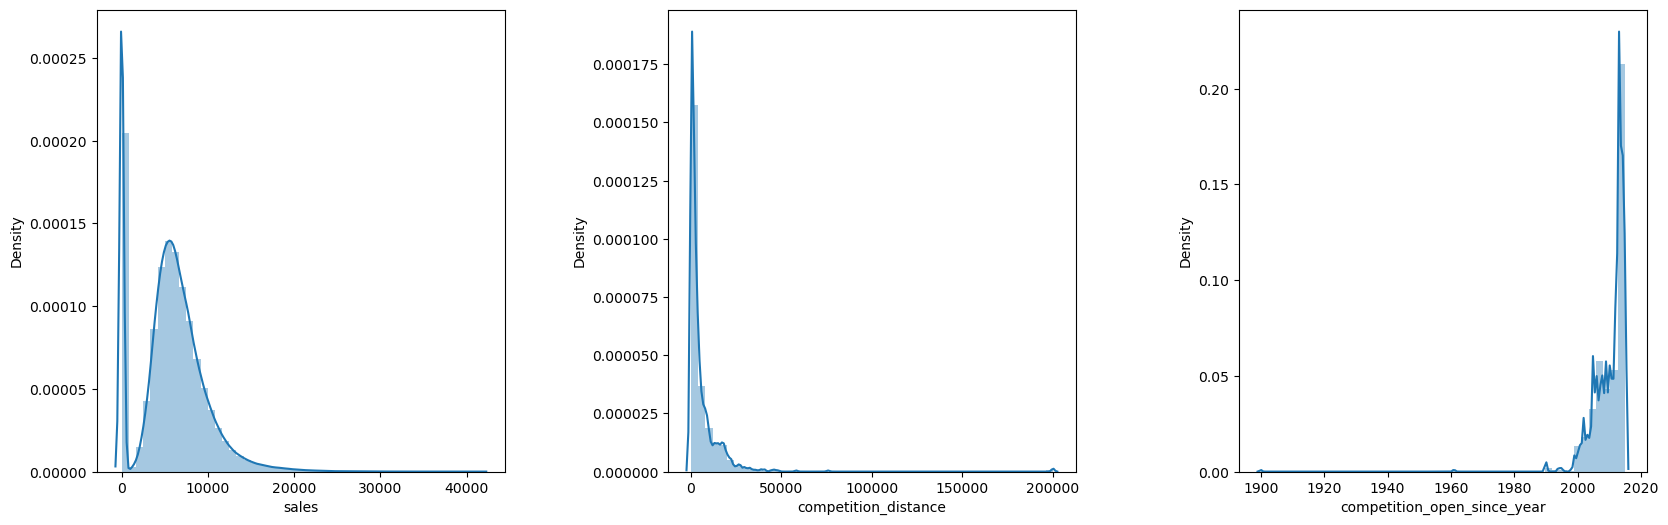

In [44]:
plt.figure(figsize = (20,6))

plt.subplot(131)
sns.distplot(df1["sales"])

plt.subplot(132)
sns.distplot(df1["competition_distance"])

plt.subplot(133)
sns.distplot(df1["competition_open_since_year"])

plt.subplots_adjust(wspace = 0.4)

1. For sales, which is our target, kurtosis is close to 1. This means the peak is not very high. Since median is less than mean, with sknewness around 0.64, we see a slightly left skewness. This value of skew is closer to a normal distribution. This considerations may be seen in the distribution chart for sales.

2. However, for competition distance, kurtosis is around 147. This represents a high peak and the existence of long tails. As the median is a way less than the mean, this results in skewness around 10. We may see a very proeminent skewness to the left in the distribution chart for competition distance.

3. A different behavior may be seen in the distribution chart for competition open since year. It has a -7 skewness, which represents a proeminent right skew. Since kurtosis is around 124, we see a high peak and a long tail in the distribution chart.

### 1.7.2. Categorical attributes

Let's begin with the unique value of each categorical attribute:

In [45]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [46]:
cat_attributes.apply(lambda x: x.unique() )

state_holiday                                          [0, a, b, c]
store_type                                             [c, a, d, b]
assortment                                                [a, c, b]
promo_interval    [0, Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Jun,...
month_map         [Jul, Jun, May, Apr, Mar, Feb, Jan, Dec, Nov, ...
dtype: object

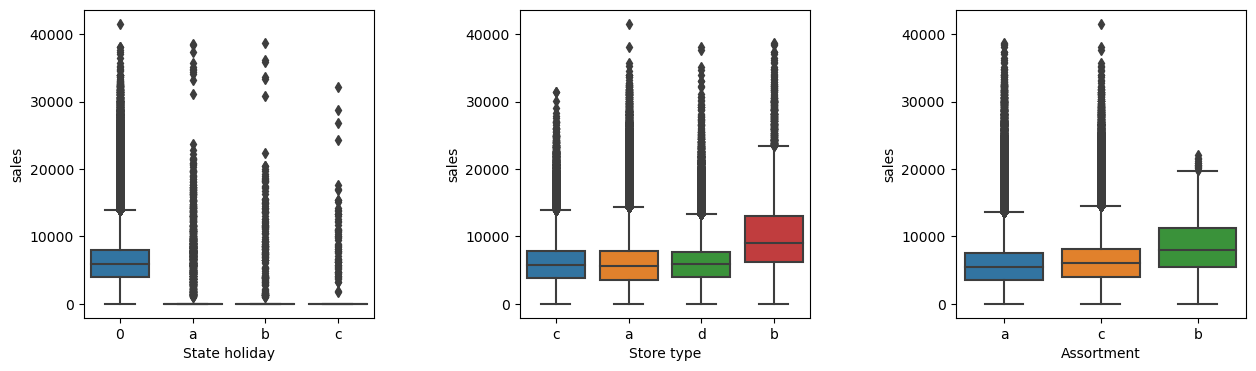

In [47]:
plt.figure(figsize = (15,4))

plt.subplot(131)
sns.boxplot(x="state_holiday" , y="sales", data=df1)
plt.xlabel("State holiday", fontsize=10)

plt.subplot(132)
sns.boxplot(x="store_type" , y="sales", data=df1)
plt.xlabel("Store type", fontsize=10)


plt.subplot(133)
sns.boxplot(x="assortment" , y="sales", data=df1)
plt.xlabel("Assortment", fontsize=10)

plt.subplots_adjust(wspace = 0.5)

For state holiday, we may perform a treatment. As we desire to see only the bevaior of holidays, we should ignore when this field is 0. Additionally, we must avoid when the sales are equal to 0. By doing this, we may see a better chart.

Text(0.5, 0, 'State holiday')

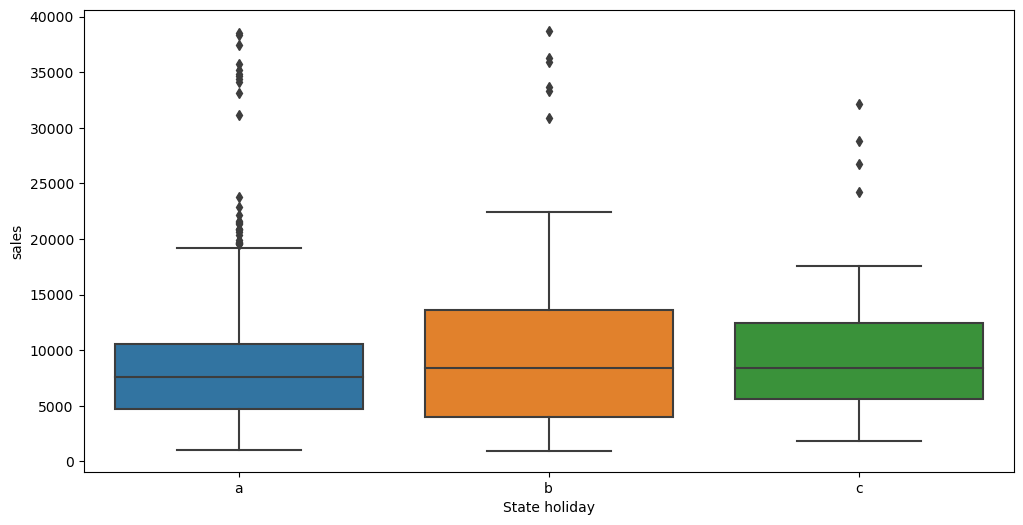

In [48]:
plt.figure(figsize = (12, 6))

aux1 = df1[(df1["state_holiday"] != "0") & (df1["sales"] > 0)]
sns.boxplot(x="state_holiday" , y="sales", data=aux1)
plt.xlabel("State holiday", fontsize=10)

1. We have higher sales for stete holidays of type b and c. Yet, b has a more homogeneous distribution around the median, that's it, for 25 and 75 quartiles.
2. Store type b has the highest sales values.
3. Assertment c presented the highest values for sales and also has much less outliers.

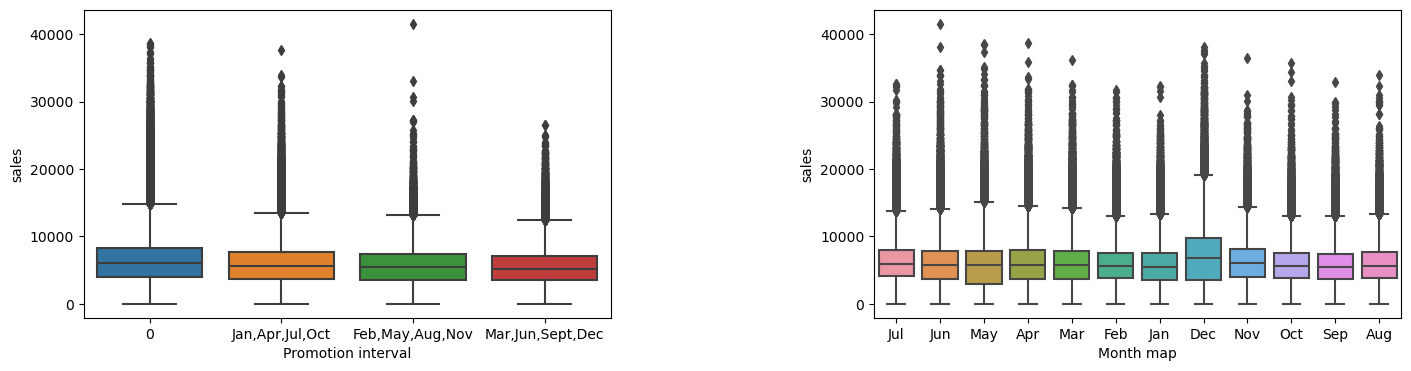

In [49]:
plt.figure(figsize = (17,4))

plt.subplot(121)
sns.boxplot(x="promo_interval" , y="sales", data=df1)
plt.xlabel("Promotion interval", fontsize=10)

plt.subplot(122)
sns.boxplot(x="month_map" , y="sales", data=df1)
plt.xlabel("Month map", fontsize=10)

plt.subplots_adjust(wspace = 0.5)

Text(0.5, 0, 'Promotion interval')

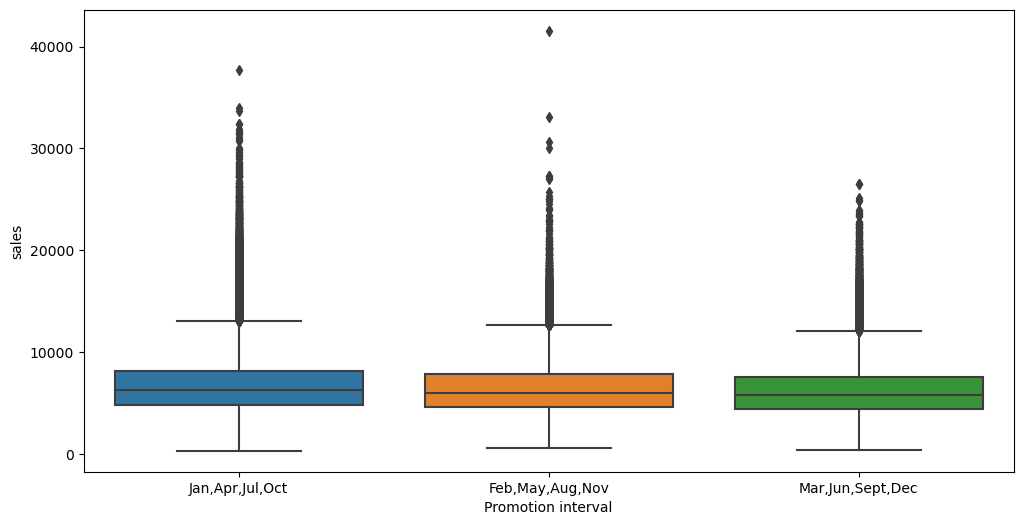

In [50]:
plt.figure(figsize = (12, 6))

aux2 = df1[(df1["promo_interval"] != 0) & (df1["sales"] > 0)]
sns.boxplot(x="promo_interval" , y="sales", data=aux2)
plt.xlabel("Promotion interval", fontsize=10)

1. Promotion interval equals to Jan, Apr, Jul, Oct presented a slightly higher sales. 
2. December is the month with the highest sales. 

# 2. Feature Engineering

In this section, we derived new features from the original ones. This section is important to make the dataset the most complete as possible to following analysis. Additionally, we enhance the model performance by deriving new features. 

This is the section 2 because we always must create new features before Exploratory Data Analysis (EDA) section. Thus, in EDA, we evaluate them.  

In [51]:
df2 = df1.copy()

## 2.1. Hypotheses mind map

To generate some hypotheses, firstly we must make a mind map in order to identify the aspects of the business. For this project, we identified 5 reasons to enhance the daily store sales: location, customers, stores, seasonality, and products. The reasons and their criteria are down here.

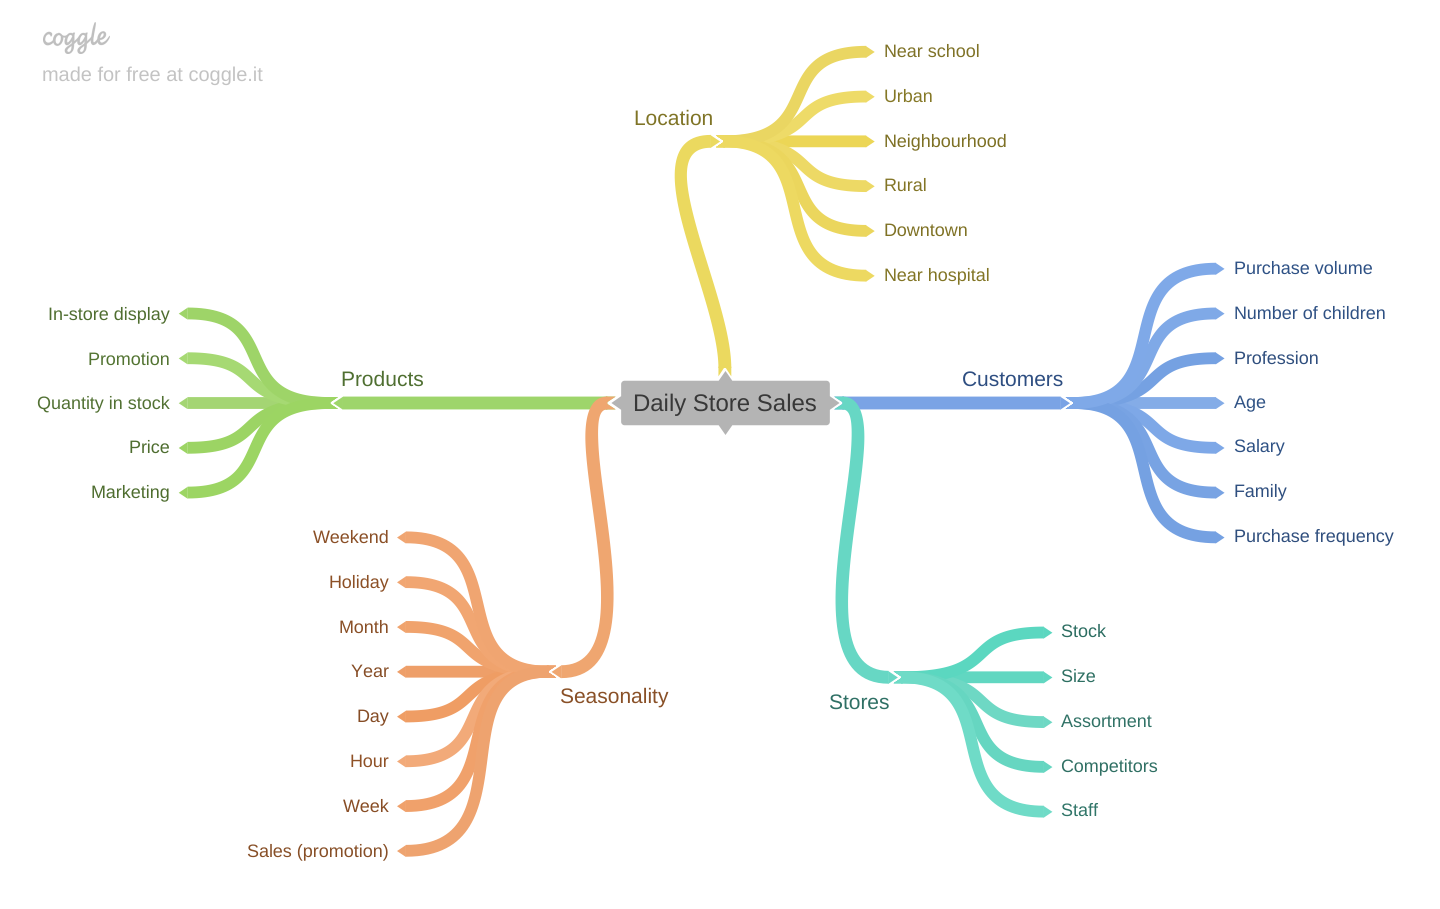

In [52]:
Image("images/HypothesesMindMap.png")

## 2.2. Hypotheses generation

Based on the mind map above, we created 3 hypotheses sections which may be seen below. 

### 2.1.1. Stores hypotheses

**1.** Stores with a higher number of staff should have higher sales.

**2.** Stores with larger stocks should have higher sales. 

**3.** Stores with larger sizes should have higher sales. 

**4.** Stores with bigger assortments should have higher sales.

**5.** Stores with closer competitors should have lower sales. 

**6.** Stores with long time competitors should have higher sales. 

### 2.1.2. Products hypotheses

**1.** Stores with higher investiments in marketing should have higher sales. 

**2.** Stores with higher in-store display should have higher sales.

**3.** Stores with lower product prices should have higher sales.

**4.** Stores with lower product prices for longer periods of time should have higher sales.

**5.** Stores with active promotions for longer periods should have higher sales.

**6.** Stores with more subsequent promotions should have higher sales. 

### 2.1.3. Seasonality hypotheses

**1.** Stores which join more holidays should have lower sales.

**2.** Stores which work in the second semester of the year should have higher sales.

**3.** Stores which work on weekends should have higher sales.

**4.** Stores which work on Christimas holiday should have higher sales.

**5.** Stores should have higher sales over year. 

**6.** Stores should have higher sales after day 10 for every month. 

**7.** Stores should have lower sales on weekends.

**8.** Stores should have lower sales on school holidays. 

## 2.3. Hypotheses final list

To create the final list, we must think about the hypotheses which may be tested through available data. The mind map works as a brainstorming to help evaluate different scenarios. Yet, we do not have data for every hypothesis. Based on this criterion, we selected the final list down here. 

**1.** Stores with bigger assortments should have higher sales.

**2.** Stores with closer competitors should have lower sales.

**3.** Stores with long time competitors should have higher sales.

**4.** Stores with active promotions for longer periods should have higher sales.

**5.** Stores with more subsequent promotions should have higher sales.

**6.** Stores which work on Christimas holiday should have higher sales.

**7.** Stores should have higher sales over year.

**8.** Stores which work in the second semester of the year should have higher sales.

**9.** Stores should have higher sales after day 10 for every month.

**10.** Stores should have lower sales on weekends.

**11.** Stores should have lower sales on school holidays.

## 2.4. Feature engineering

In [53]:
# year
df2["year"] = df2["date"].dt.year 

# month
df2["month"] = df2["date"].dt.month 

# day
df2["day"] = df2["date"].dt.day 

# week of year
df2["week_of_year"] = df2["date"].dt.weekofyear 

# year week
df2["year_week"] = df2["date"].dt.strftime("%Y-%W") 

# competition since
df2["competition_since"] = df2.apply(lambda x: datetime(year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1), axis=1)
df2["competition_time_month"] = ((df2["date"] - df2["competition_since"])/30).apply(lambda x: x.days).astype(int)


# promo since
df2["promo_since"] = df2["promo2_since_year"].astype(str) + "-" + df2["promo2_since_week"].astype(str)
df2["promo_since"] = df2["promo_since"].apply(lambda x: datetime.strptime(x + "-1", "%Y-%W-%w") - timedelta(days=7))
df2["promo_time_week"] = ((df2["date"] - df2["promo_since"])/30).apply(lambda x: x.days).astype(int)

# assortment
df2["assortment"] = df2["assortment"].apply(lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended")

# state holiday
df2["state_holiday"] = df2["state_holiday"].apply(lambda x: "public_holiday" if x == "a" else "easter_holiday" if x == "b" else "christmas" if x == "c" else "regular_day")

/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_23226/2736517694.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2["week_of_year"] = df2["date"].dt.weekofyear


In [54]:
df2.sample(5).T

,301326,372929,359647,166579,326253
store,515,47,939,445,138
day_of_week,4,4,5,3,5
date,2014-10-23 00:00:00,2014-08-07 00:00:00,2014-08-22 00:00:00,2015-03-04 00:00:00,2014-09-26 00:00:00
sales,8745.0,7104.0,5910.0,7784.0,6219.0
customers,736,894,598,1123,653
open,1,1,1,1,1
promo,1,1,1,1,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,1,0,0,0
store_type,d,a,d,a,a


# 3. Feature Filtering and Selection

The motivation of doing this section is business constraints. There are some fields that we will not use in this project due to lack of information (unavailable data) or predictability. For this project, this section is very easy to solve. However, in the real world this section demands so much more attention.

In [55]:
df3 = df2.copy()

## 3.1. Rows filtering

- We will not use open when is equal to zero. That's why open = 0 means the store was closed and then sales was also zero. It is easy to predict the value zero for sale, it happens when the store is close. Thus, we will not use this field when is 0. 
- Similarly, we want sales higher than zero. 

In [56]:
df3 = df3[(df3["open"] != 0) & (df3["sales"] > 0)]

## 3.2. Columns selection

- We may not predict the number of customers during the forecast. 
- Since we only have open = 1, this does not bring any variation. Thus, we do not need this column anymore. 
- We do not need column promo_interval, since we now have this information through column is_promo. 
- We either will not use column month_map because we now have the column month. 

In [57]:
cols_drop = ["customers", "open", "promo_interval", "month_map"]
df3 = df3.drop(cols_drop, axis=1)

# 4. Exploratory Data Analysis (EDA)

This section is important to understand the features and their impact. If we should list three objectives of this procedure, we would choose:

1. To gain business experience.
2. Validate business hypotheses. (insights)
3. Identify the most important features for the Machine Learning model. 

There are three types of analysis we are going to perform in this project: 

1. Univariate analysis: we must evaluate every feature separately. 
2. Bivariate analysis: here we evaluate how a feature impacts the target. 
3. Multivariate analysis: mainly we aim for the correlation of the features and their impact on the target.  

In [58]:
df4 = df3.copy()

## 4.1. Univariate Analysis 

### 4.1.1. Target feature

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


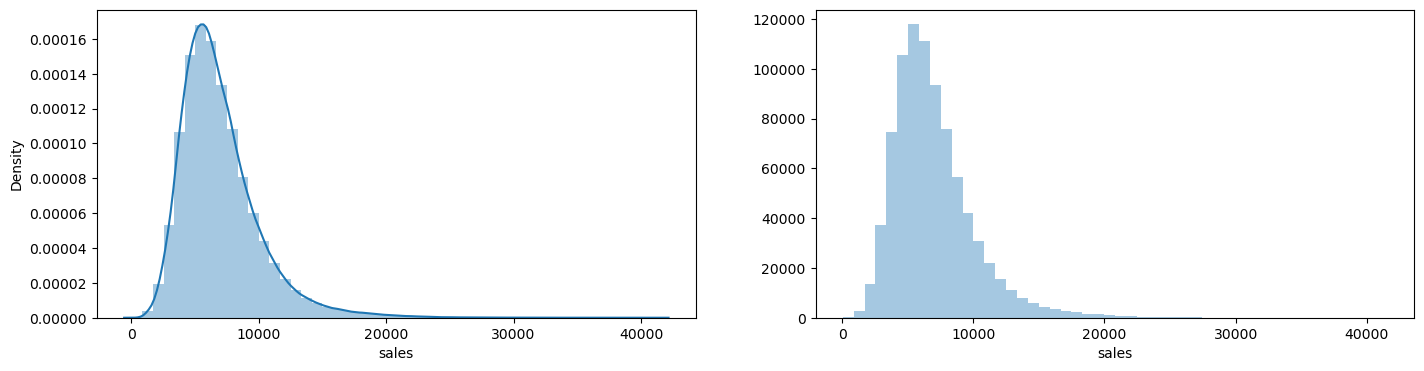

In [59]:
plt.figure(figsize = (17,4))

plt.subplot(1,2,1)
sns.distplot(df4["sales"])

plt.subplot(1,2,2)
sns.distplot(df4["sales"], kde=False)

plt.subplots_adjust(wspace = 0.2)

This distribution is close to a normal one. Yet, it has a kurtosis and also a skewness to the left (positive). Although ideally we want a distribution the closest to a normal as possible, this result is still enough to train the Machine Learning model.

In case we would rather modify the distribution in order to approximate it to a normal, we could apply the logarithm to the target feature, as follows:

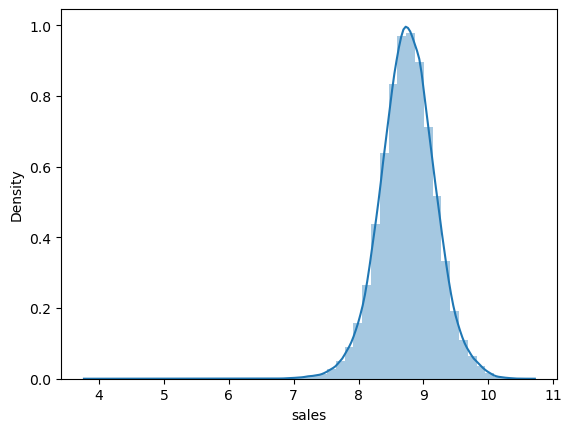

In [60]:
sns.distplot(np.log1p(df4["sales"]));

### 4.1.2. Numerical features

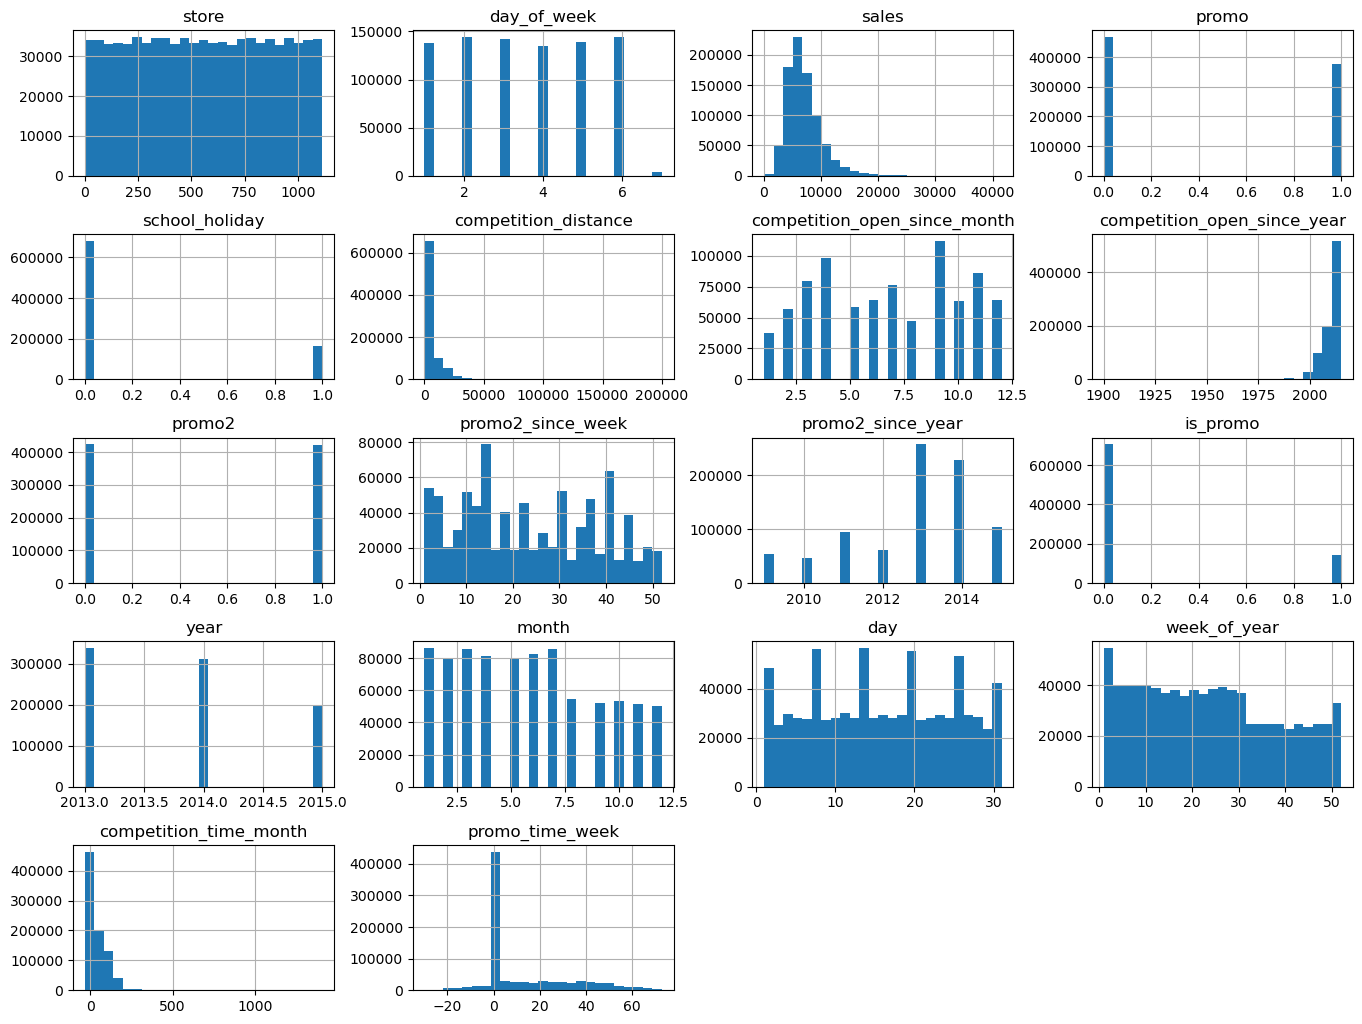

In [61]:
num_attributes = df4.select_dtypes(include=["int64", "float64"])

num_attributes.hist(bins=25);
plt.subplots_adjust(left=0.5, bottom=0.3, right=2.5, top=2.3, wspace=0.3, hspace=0.4)

**Store**, **day**, **promo2** and **day_of_week** almost do not offer relevant information to the model, since their values slightly vary from each other. The main insights from this analysis may be seen below:

- Sunday (7) is the least frequent day for purchases. (day_of_week)
- The majority of sales are around EUR 5000. (sales)
- The competitors distance are majority very near, close to zero meters. (competition_distance)
- The stores were open majority afer 2000's. (competition_open_since_year)
- Months between January and July are the most frequent for sales. (month)
- We have much more sales when there is no promotion. (is_promo)
- Although day (of the month) does not vary so much, there are some peaks we may explore. (day) 
- We have much more sales between 2013 and 2014 (promo2_since_year). Since we only have information after 2013 (year), we may suppose we have registered sales after this period. 

### 4.1.3. Categorical features

In [62]:
cat_attributes = df4.select_dtypes(exclude=["int64", "float64", "datetime64[ns]"])
cat_attributes.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


#### State holiday

In [63]:
df4["state_holiday"].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


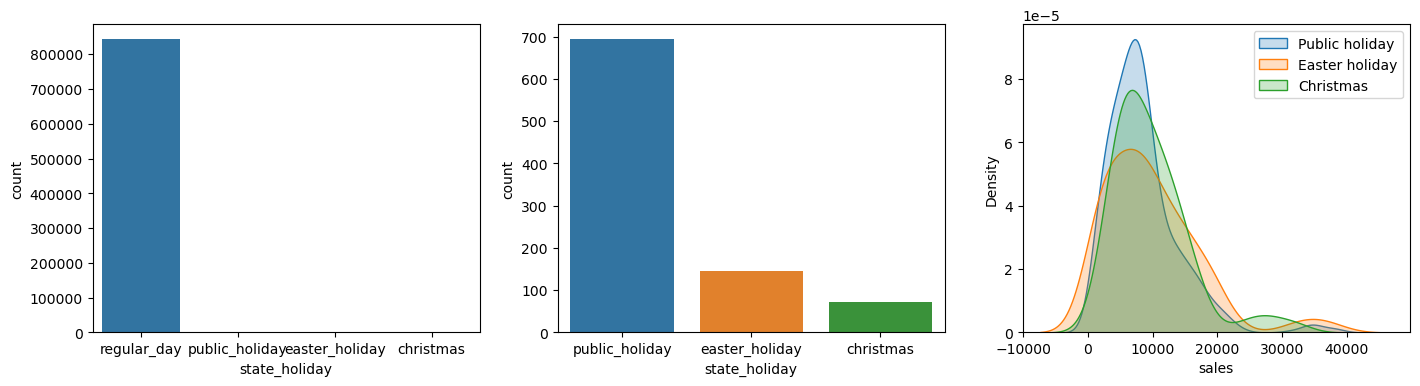

In [64]:
plt.figure(figsize = (17,4))

plt.subplot(1,3,1)
sns.countplot(df4["state_holiday"])

plt.subplot(1,3,2)
aux_sh = df4[df4["state_holiday"] != "regular_day"]
sns.countplot(aux_sh["state_holiday"])

plt.subplot(1,3,3)
sns.kdeplot(df4[df4["state_holiday"] == "public_holiday"]["sales"], label="Public holiday", shade=True)
sns.kdeplot(df4[df4["state_holiday"] == "easter_holiday"]["sales"], label="Easter holiday", shade=True)
sns.kdeplot(df4[df4["state_holiday"] == "christmas"]["sales"], label="Christmas", shade=True)
plt.legend();

In [65]:
df4["date"].max()

Timestamp('2015-07-31 00:00:00')

We should have the same count for Easter and for Christmas. However, it is not what we see in the second count plot. This may be explained by seen the max date. Since the max date is in July, we counted the sales in Easter for 2015, but did not for Christmas. 

While we have much more countability for Easter, compared to Christmas, this last one has more sales volume (third chart). 

#### Store type

In [66]:
df4["store_type"].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


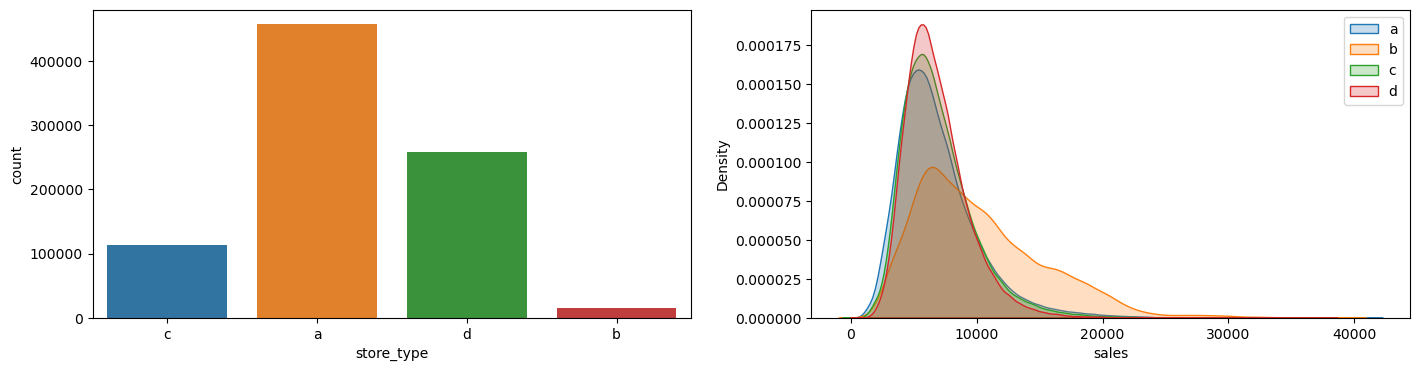

In [67]:
plt.figure(figsize = (17,4))

plt.subplot(1,2,1)
sns.countplot(df4["store_type"])

plt.subplot(1,2,2)
sns.kdeplot(df4[df4["store_type"] == "a"]["sales"], label="a", shade=True)
sns.kdeplot(df4[df4["store_type"] == "b"]["sales"], label="b", shade=True)
sns.kdeplot(df4[df4["store_type"] == "c"]["sales"], label="c", shade=True)
sns.kdeplot(df4[df4["store_type"] == "d"]["sales"], label="d", shade=True)
plt.legend();

- Store type a has a major count on our dataset. However, the sales volume is higher for store type d. 
- Store type b has the least count and also has the lowest sales volume. Yet, it has a broader range of sales. 

#### Assortment

In [68]:
df4["assortment"].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


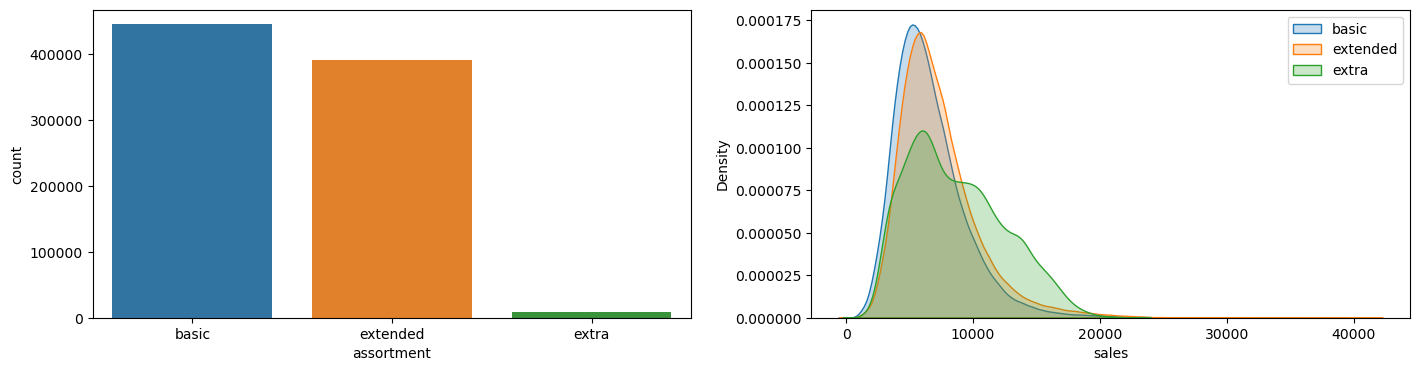

In [69]:
plt.figure(figsize = (17,4))

plt.subplot(1,2,1)
sns.countplot(df4["assortment"])

plt.subplot(1,2,2)
sns.kdeplot(df4[df4["assortment"] == "basic"]["sales"], label="basic", shade=True)
sns.kdeplot(df4[df4["assortment"] == "extended"]["sales"], label="extended", shade=True)
sns.kdeplot(df4[df4["assortment"] == "extra"]["sales"], label="extra", shade=True)
plt.legend();

- Basic, extended and extra has the same order for count and sales volume. As we expected, basic has the major count and sales volume.
- Extra has the sales volume more distributed. Assortments of type extra has a broader range of sales. 

## 4.2. Bivariate Analysis

As we have a bivariate analysis, we are going to test the hypotheses set in the section 2. In this section, we are going to evaluate the features related to the sales.

#### **H1.** Stores with bigger assortments should have higher sales.

In [70]:
aux1 = df4[["sales", "assortment"]].groupby("assortment").sum().reset_index()

aux2 = df4[["sales", "assortment", "year_week"]].groupby(["assortment", "year_week"]).sum().reset_index()
aux3 = aux2.pivot(index="year_week", columns="assortment", values="sales")
aux3.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262.0,12425669.0,269404.0
2013-01,26007250.0,22917693.0,350279.0
2013-02,17970974.0,16029584.0,377207.0
2013-03,24392076.0,21243431.0,404662.0
2013-04,19972891.0,18130077.0,363061.0


In [71]:
aux4 = aux2[aux2["assortment"] == "extra"]
aux4 = aux4.pivot(index="year_week", columns="assortment", values="sales")
aux4.head()

assortment,extra
year_week,
2013-00,269404.0
2013-01,350279.0
2013-02,377207.0
2013-03,404662.0
2013-04,363061.0


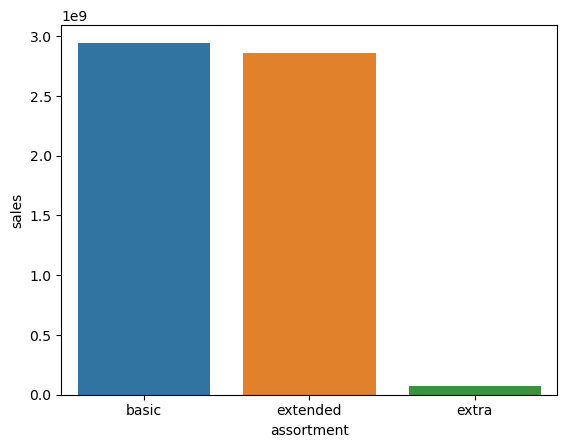

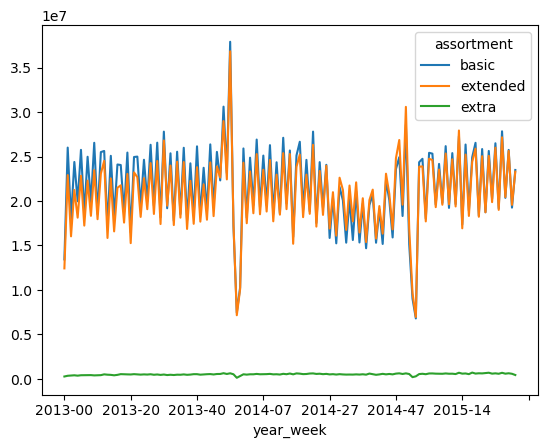

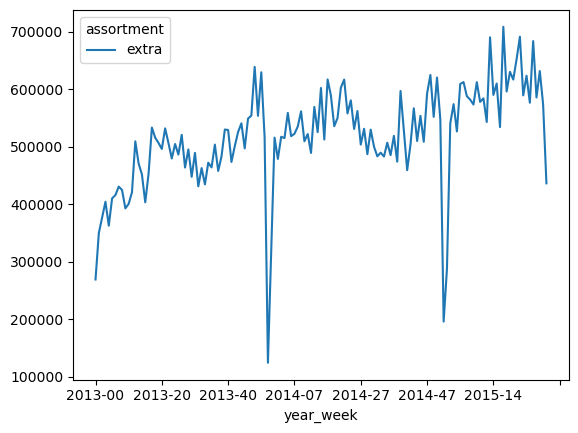

In [72]:
sns.barplot(x="assortment", y="sales", data=aux1);

aux3.plot();

aux4.plot();

**False**

- Assortments basic and extended have the highest sum of sales. Additionally, they have quite the same amount. What we must understand from this chart is that stores with bigger assortments (extra) have lower sales.
- As assortments of type extra presented the lowest sum of sales, we supposed that in some period the sales could have been higher. However, in the chart of sales per time for the three types of assortment, we do not see any moment that extra had higher sales.

#### **H2.** Stores with closer competitors should have lower sales.

To visualize, it is better to group every competition_distance into groups from 1000 to 1000 meters. 

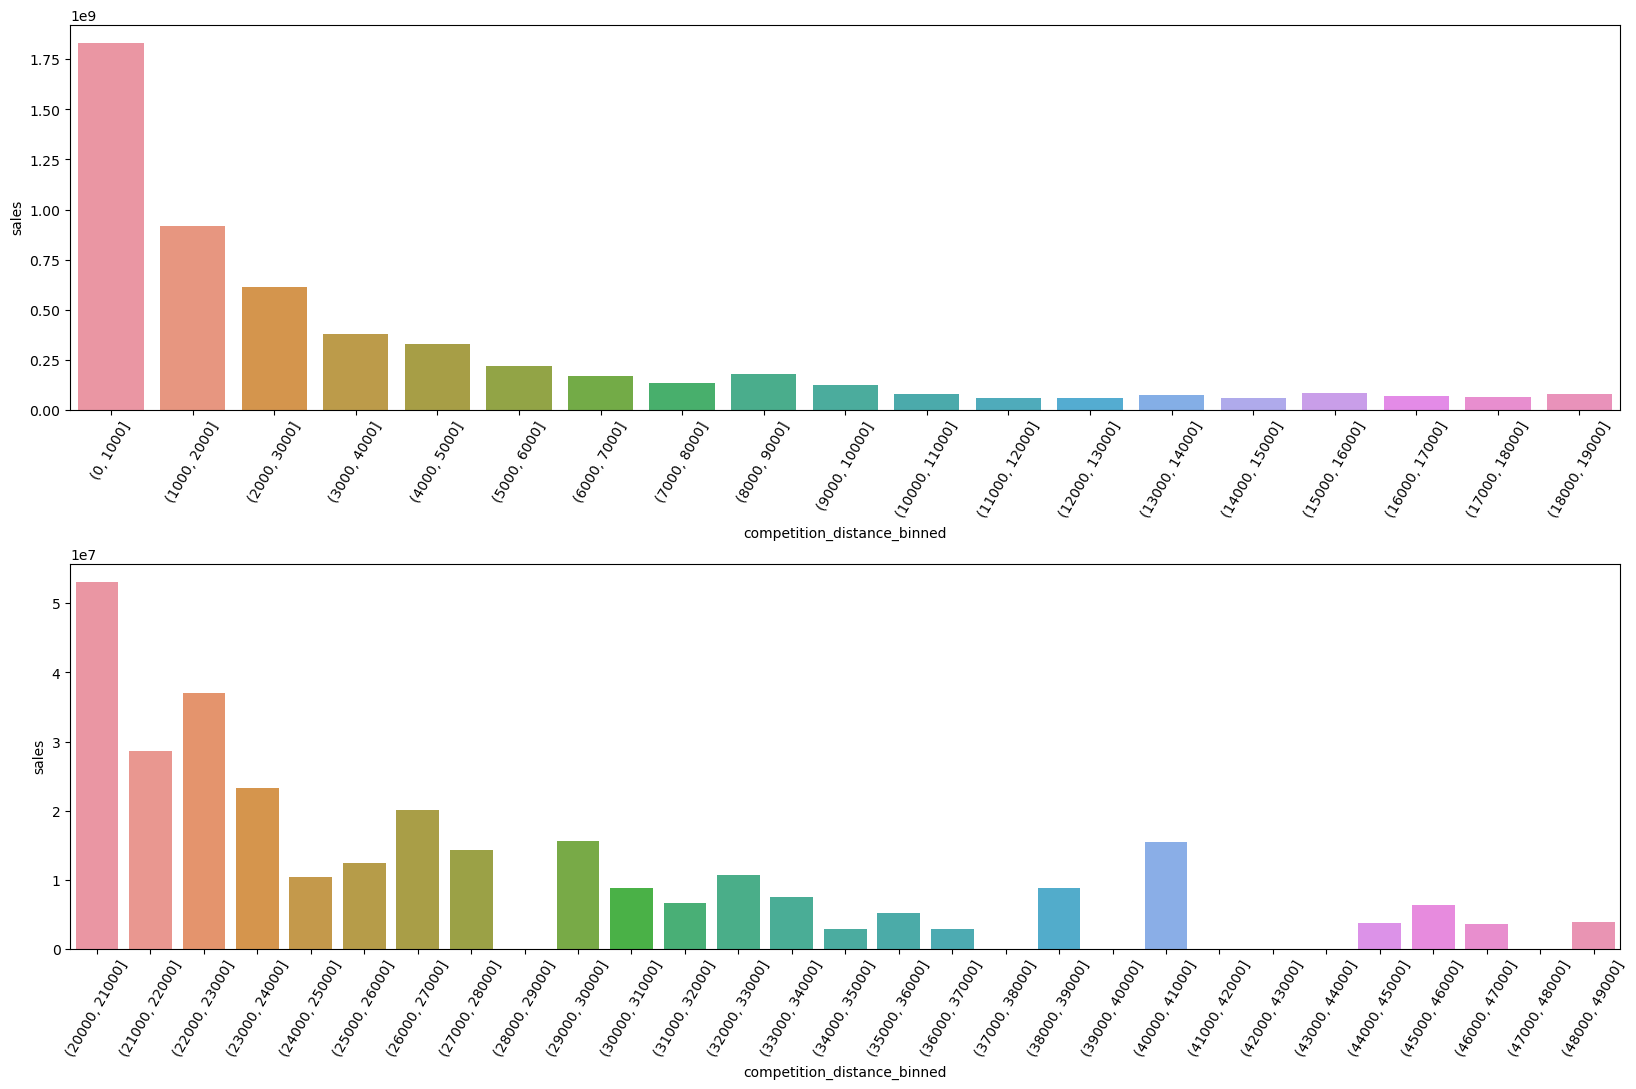

In [73]:
aux1 = df4[["sales", "competition_distance"]].groupby("competition_distance").sum().reset_index()

bins1 = list(np.arange(0, 20000, 1000))
aux1["competition_distance_binned"] = pd.cut(aux1["competition_distance"], bins=bins1)
aux2 = aux1[["sales", "competition_distance_binned"]].groupby("competition_distance_binned").sum().reset_index()

bins2 = list(np.arange(20000, 50000, 1000))
aux1["competition_distance_binned"] = pd.cut(aux1["competition_distance"], bins=bins2)
aux4 = aux1[["sales", "competition_distance_binned"]].groupby("competition_distance_binned").sum().reset_index()

plt.figure(figsize = (20,12))

plt.subplot(2,1,1)
sns.barplot(x="competition_distance_binned", y="sales", data=aux2)
plt.xticks(rotation=60);

plt.subplot(2,1,2)
sns.barplot(x="competition_distance_binned", y="sales", data=aux4)
plt.xticks(rotation=60);

plt.subplots_adjust(hspace=0.4)

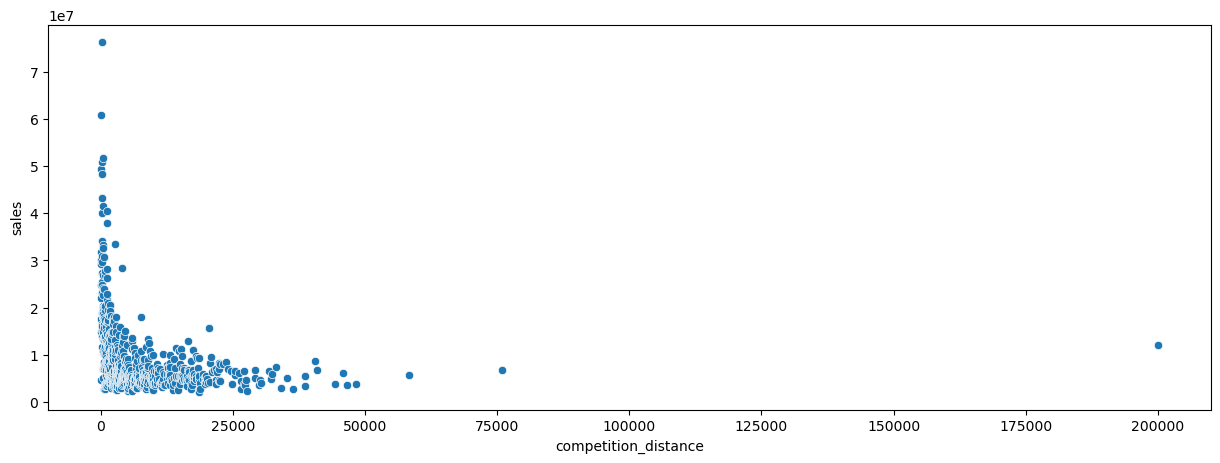

In [74]:
plt.figure(figsize = (15,5))

sns.scatterplot(x="competition_distance", y="sales", data=aux1);

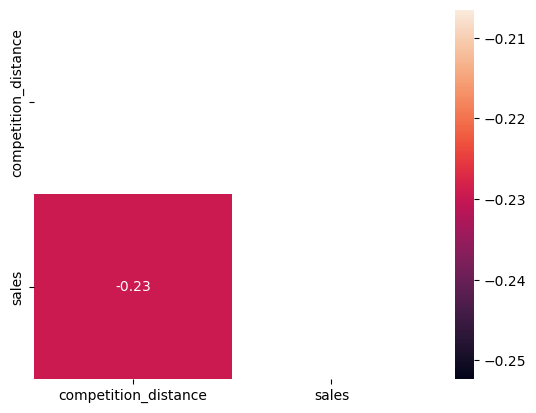

In [75]:
mask = np.zeros_like(aux1.corr(method="pearson"), dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(aux1.corr(method="pearson"), mask = mask, annot=True);

**False**

- There is a tendency of sales which correlates with the competition distance. Yet, the closer the competition distance, the higher is the sales sum.
- Looking at the heatmap above, we may see that competition distance and sales have a weak and inverse correlation (-0.23). That means, the higher the sales, the lower is the competition distance. 

#### **H3.** Stores with long time competitors should have higher sales.

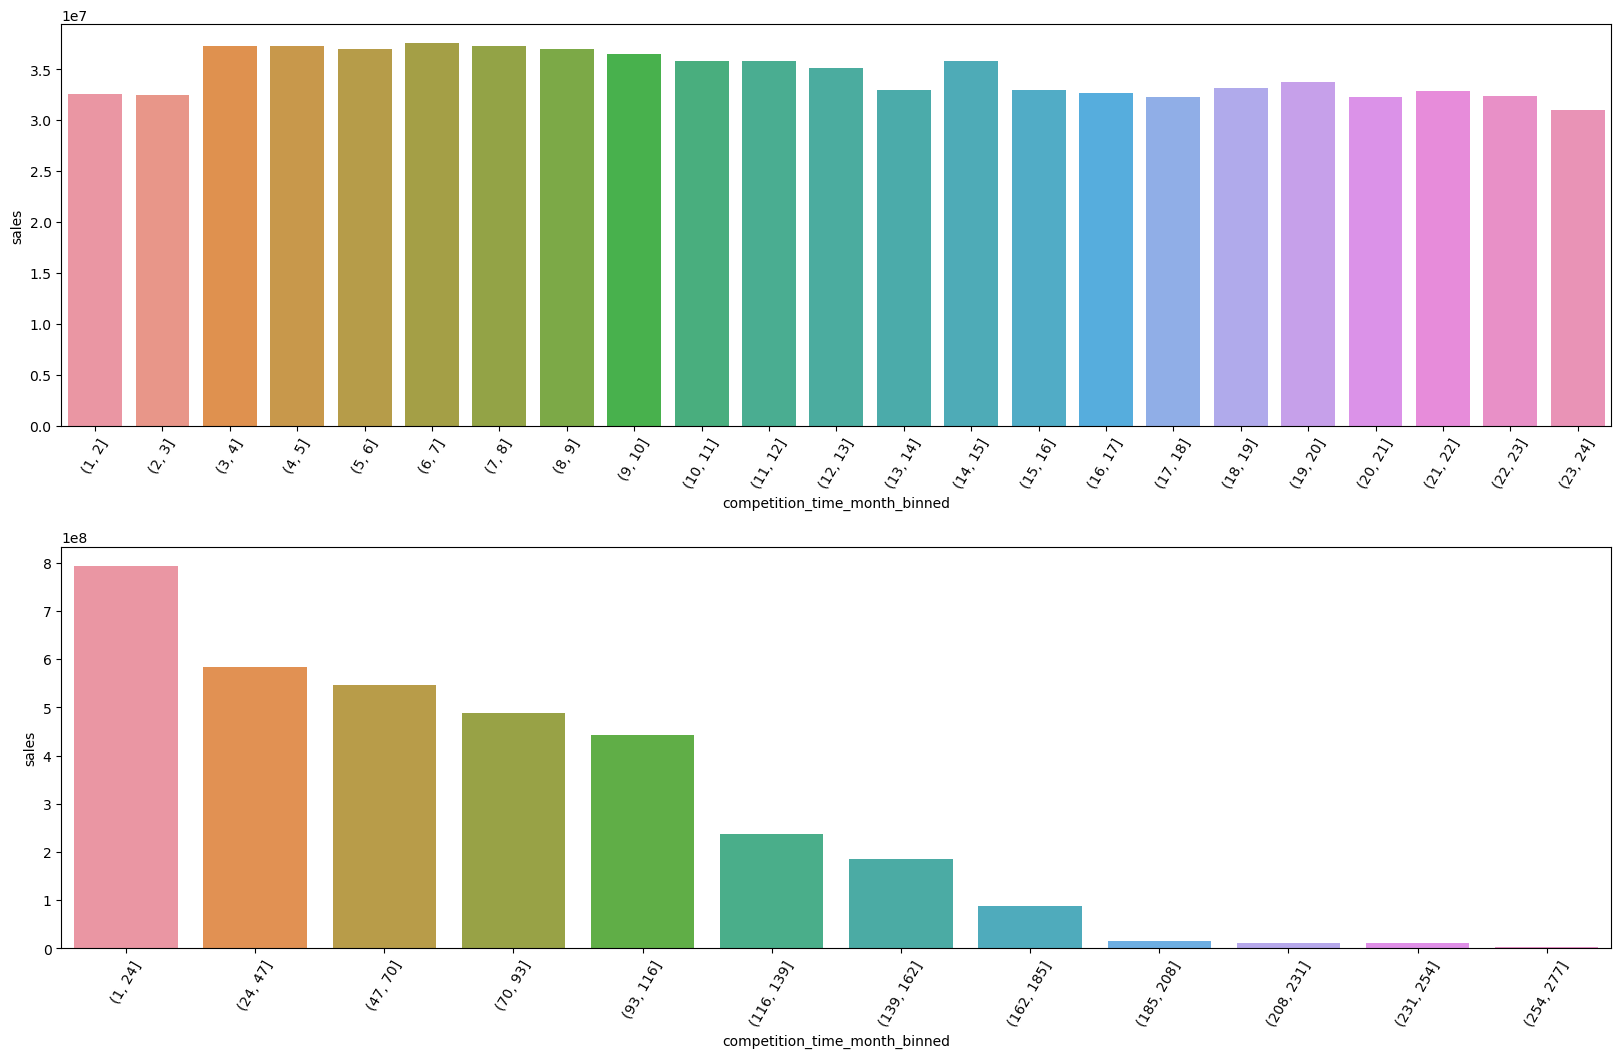

In [76]:
aux1 = df4[df4["competition_time_month"] > 0]
aux1 = aux1[["competition_time_month", "sales"]].groupby("competition_time_month").sum().reset_index()

bins1 = list(np.arange(1, 25, 1))
aux1["competition_time_month_binned"] = pd.cut(aux1["competition_time_month"], bins=bins1)
aux2 = aux1[["sales", "competition_time_month_binned"]].groupby("competition_time_month_binned").sum().reset_index()

bins2 = list(np.arange(1, 300, 23))
aux1["competition_time_month_binned"] = pd.cut(aux1["competition_time_month"], bins=bins2)
aux3 = aux1[["sales", "competition_time_month_binned"]].groupby("competition_time_month_binned").sum().reset_index()

plt.figure(figsize = (20,12))

plt.subplot(2,1,1)
sns.barplot(x="competition_time_month_binned", y="sales", data=aux2)
plt.xticks(rotation=60);

plt.subplot(2,1,2)
sns.barplot(x="competition_time_month_binned", y="sales", data=aux3)
plt.xticks(rotation=60);

plt.subplots_adjust(hspace=0.3)

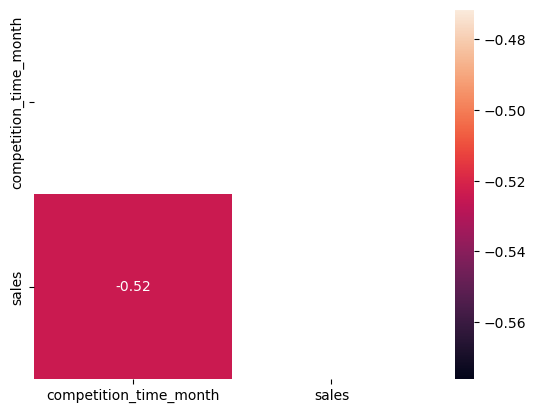

In [77]:
mask = np.zeros_like(aux1.corr(method="pearson"), dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(aux1.corr(method="pearson"), mask = mask, annot=True);

**False**

- In the first two years, the sum of sales varies too little as the time goes by. But analyzing groups of 24 months, we see that stores with competitors which were open more recently have higher sales. This value tends to decrease with time. 
- We found a moderate Pearson correlation between competition time month and sales: -0.52. It reinforces that stores with competitors open more recently have higher sales: the lower the competition time month, the higher the sale.

#### H4. Stores with active promotions for longer periods should have higher sales.

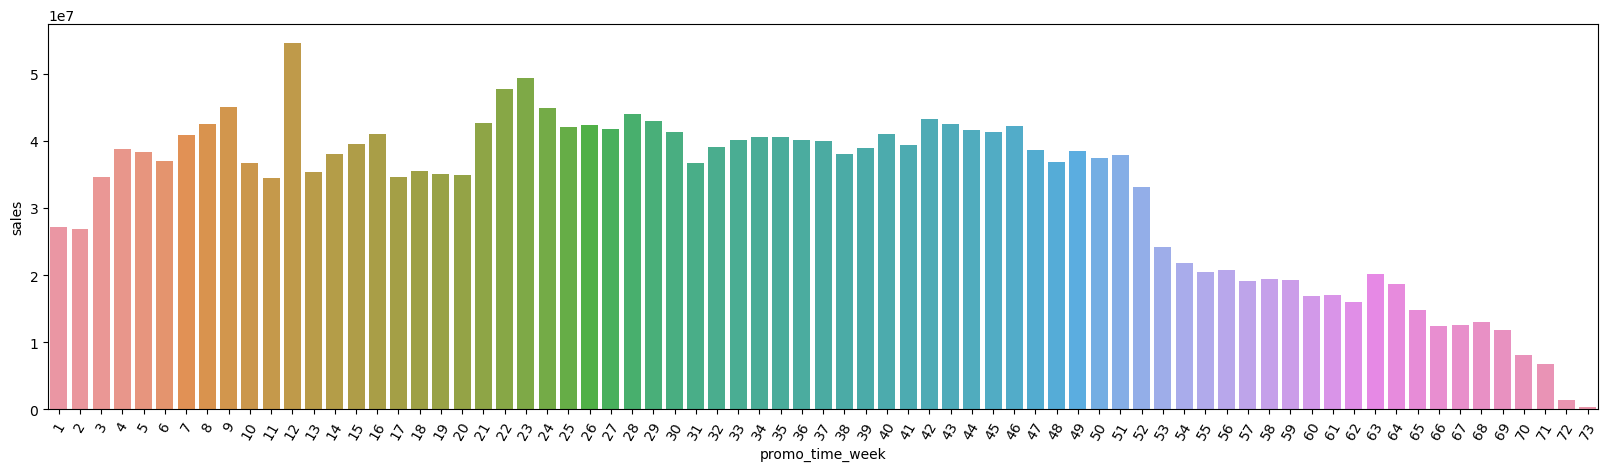

In [78]:
aux1 = df4[df4["promo_time_week"] > 0]
aux1 = aux1[["sales", "promo_time_week"]].groupby("promo_time_week").sum().reset_index()

plt.figure(figsize = (20,5))

sns.barplot(x="promo_time_week", y="sales", data=aux1)
plt.xticks(rotation=60);

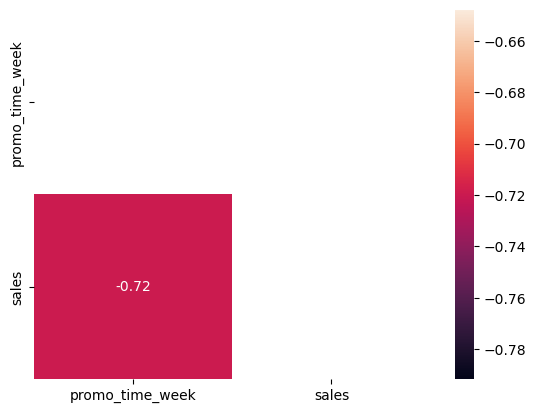

In [79]:
mask = np.zeros_like(aux1.corr(method="pearson"), dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(aux1.corr(method="pearson"), mask = mask, annot=True);

**False**

- Few weeks after the beginning of the promotion is still profitable. The sum of sales is kept high. However, after some weeks, the sales falls down. 
- We may confirm this observation above by lookin at the heatmap. Sales and promo time week are negative correlative with a value of -0.72 (good correlation) of Pearson coefficient. This means the more promo time week, the lower the sales.  

#### H5. Stores with more subsequent promotions should have higher sales.

In [80]:
aux1 = df4[["sales", "promo", "promo2"]].groupby(["promo", "promo2"]).sum().reset_index()
aux1

,promo,promo2,sales
0,0,0,1.482612e+09
1,0,1,1.289362e+09
2,1,0,1.628931e+09
3,1,1,1.472276e+09


Observing the table above, stores with consecutive promotions (promo2 = 1) did not present higher sales. 

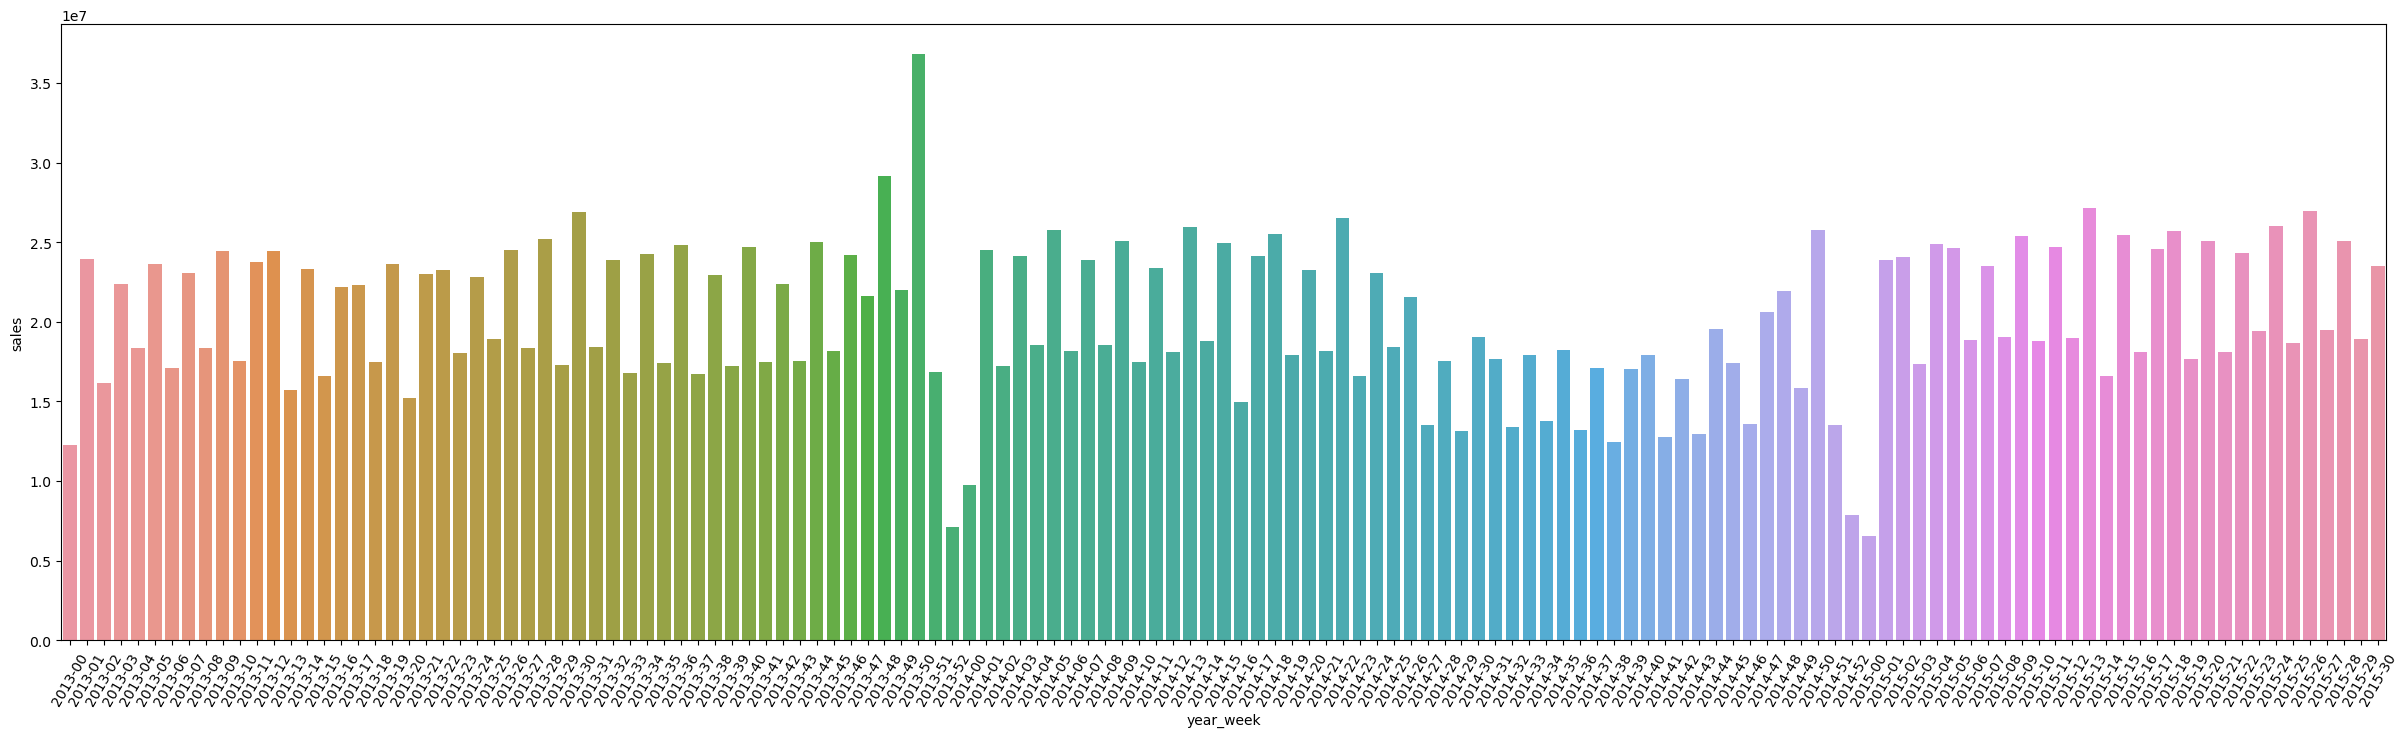

In [81]:
aux2 = df4[df4["promo2"] == 1][["sales", "year_week"]].groupby("year_week").sum().reset_index()

plt.figure(figsize = (30,8))

sns.barplot(x="year_week", y="sales", data=aux2)
plt.xticks(rotation=60);

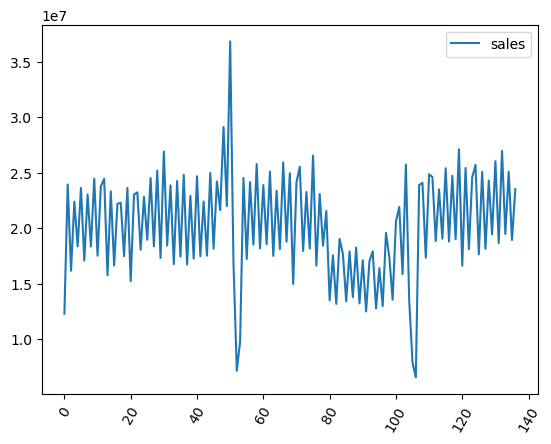

In [82]:
aux2 = df4[df4["promo2"] == 1][["sales", "year_week"]].groupby("year_week").sum().reset_index()

aux2.plot()
plt.xticks(rotation=60);

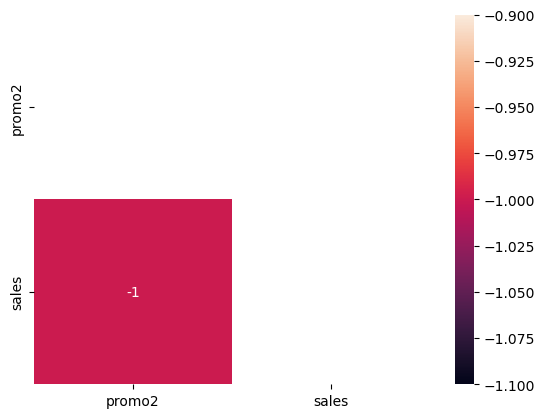

In [83]:
aux3 = df4[["sales", "promo2"]].groupby("promo2").sum().reset_index()

mask = np.zeros_like(aux3.corr(method="pearson"), dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(aux3.corr(method="pearson"), mask = mask, annot=True);

**False**

- We did not observe higher sales for consecutive promotions in the table above.
- The charts with consecutive promotions per year week did not present an increase with time. 
- Pearson correlation coefficient equals to -1 (extremely correlated) shows that the higher the sales, the lower consecutive promotions. 

#### H6. Stores which work on Christimas holiday should have higher sales.

<AxesSubplot:xlabel='year', ylabel='sales'>

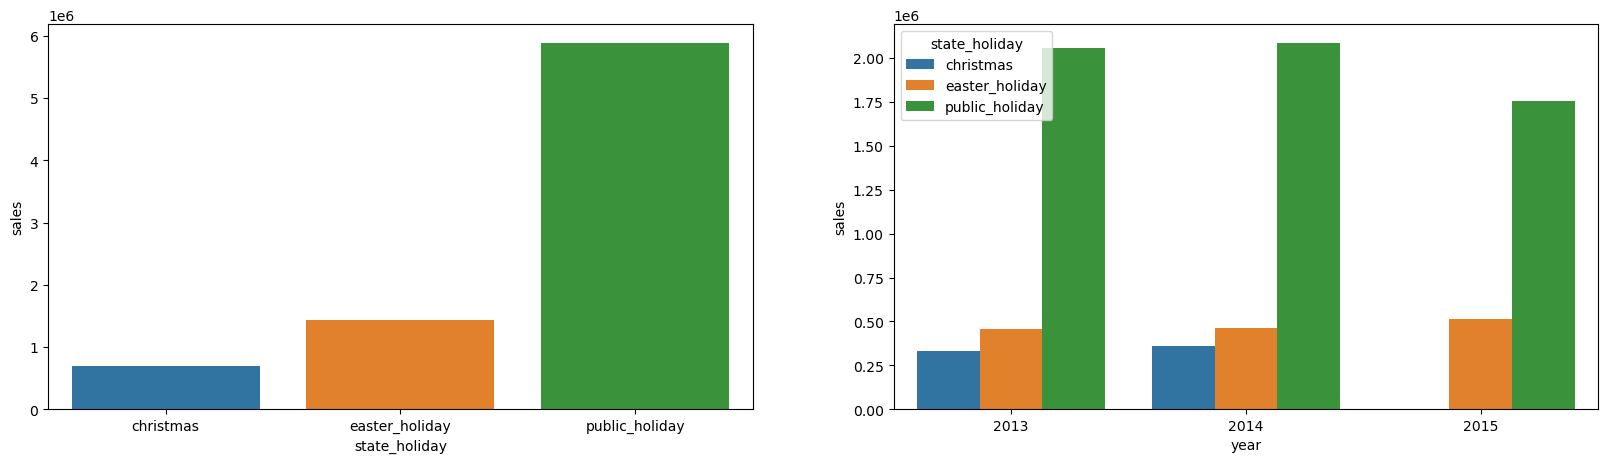

In [84]:
aux1 = df4[df4["state_holiday"] != "regular_day"]
aux2 = aux1[["sales", "state_holiday"]].groupby("state_holiday").sum().reset_index()

plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
sns.barplot(x="state_holiday", y="sales", data=aux2);

aux3 = aux1[["sales", "state_holiday", "year"]].groupby(["year", "state_holiday"]).sum().reset_index()

plt.subplot(1,2,2)
sns.barplot(x="year", y="sales", hue="state_holiday", data=aux3)

In [85]:
df_test = df4[df4["state_holiday"] != "regular_day"].copy()
df_test = pd.get_dummies(df_test, columns=['state_holiday'])

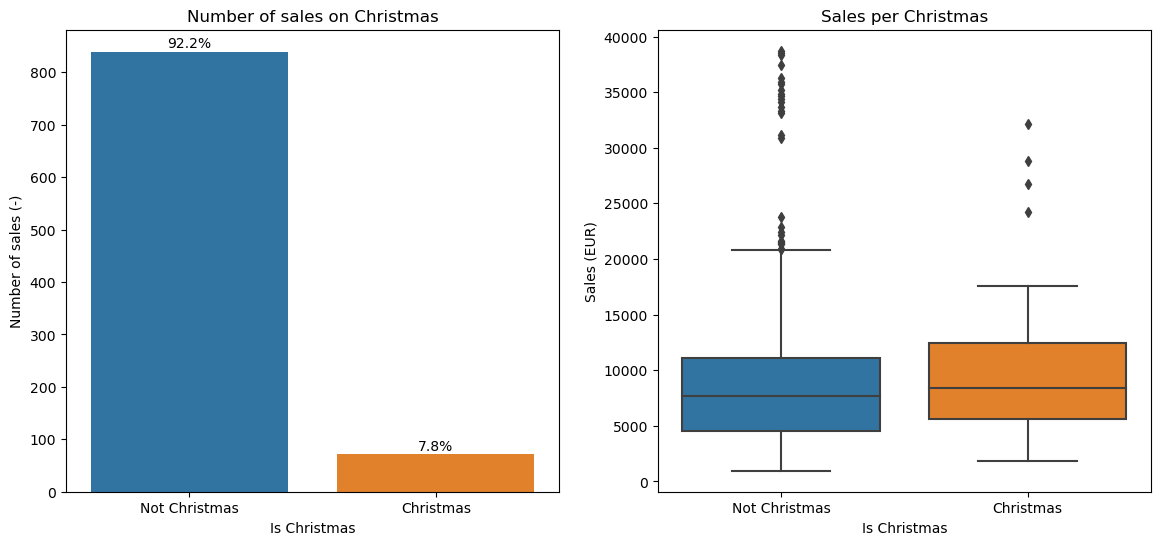

In [86]:
plt.figure(figsize = (14,6))
  
plt.subplot(121)
ax1 = sns.countplot(x = 'state_holiday_christmas', data = df_test)
for p in ax1.patches:
    ax1.annotate(format(str((p.get_height()/len(df_test)*100).round(1)) + '%'), 
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', 
                va='center', 
                xytext=(0,6),
                textcoords='offset points')
ax1 = plt.title("Number of sales on Christmas", fontsize=12)
ax1 = plt.xlabel("Is Christmas", fontsize=10)
ax1 = plt.ylabel("Number of sales (-)", fontsize=10)
ax1 = plt.xticks(np.arange(2), ('Not Christmas','Christmas'))

plt.subplot(122)
ax2 = sns.boxplot(x = 'state_holiday_christmas', y = 'sales', data = df_test)
ax2 = plt.title("Sales per Christmas", fontsize=12)
ax2 = plt.xlabel("Is Christmas", fontsize=10)
ax2 = plt.ylabel("Sales (EUR)")
ax2 = plt.xticks(np.arange(2), ('Not Christmas','Christmas'))
  
plt.subplots_adjust(wspace = 0.20)
plt.show()

In [87]:
median_sales = df_test[['sales','state_holiday_christmas']].groupby('state_holiday_christmas').median()
median_sales.rename(columns={'sales':'Median sales (EUR)'}, inplace=True)
median_sales.index.name = 'Christmas status'

median_rel = ((median_sales.iloc[1][0] - median_sales.iloc[0][0])*(100/median_sales.iloc[0][0])).round(2)
  
print("\n\n", median_sales)
print(f"\nSales on Christmas are {median_rel}% higher, on median, than those out of Christmas.")



                   Median sales (EUR)
Christmas status                    
0                             7635.0
1                             8397.0

Sales on Christmas are 9.98% higher, on median, than those out of Christmas.


**False**

- The sum of sales for every state holiday showed that Christmas has the minor amount of sales (total and for year). 
- However, Christmas has a slightly higher median of sales, compared to periods out of Christmas. 
- Sales on Christmas are around 10% higher.
- We do not have available data for the end of 2015, thus we either have data for Christmas for this year. 

#### H7. Stores should have higher sales over year.

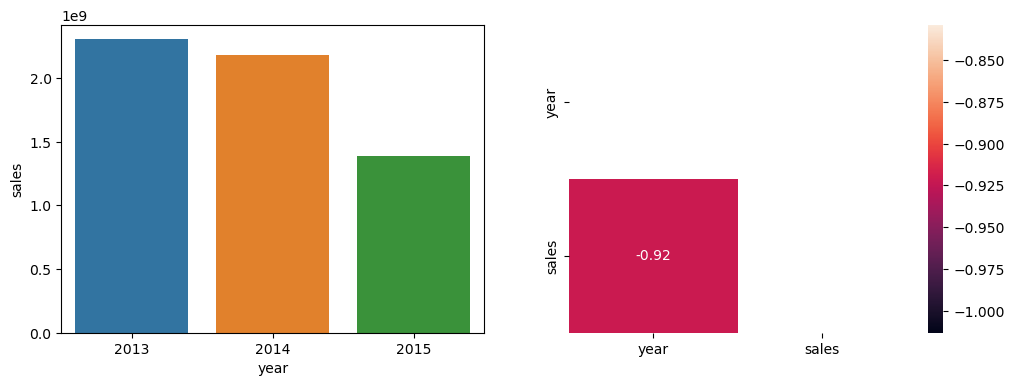

In [88]:
aux1 = df4[["sales", "year"]].groupby("year").sum().reset_index()

plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
sns.barplot(x="year", y="sales", data=aux1)

mask = np.zeros_like(aux1.corr(method="pearson"), dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method="pearson"), mask = mask, annot=True);

**False** 

- Stores presented lower sales over the years. 
- Pearson correlation coefficient equals to -0.92 (highly correlated) means that the higher the year, the lower the sales. 

#### H8. Stores which work in the second semester of the year should have higher sales.

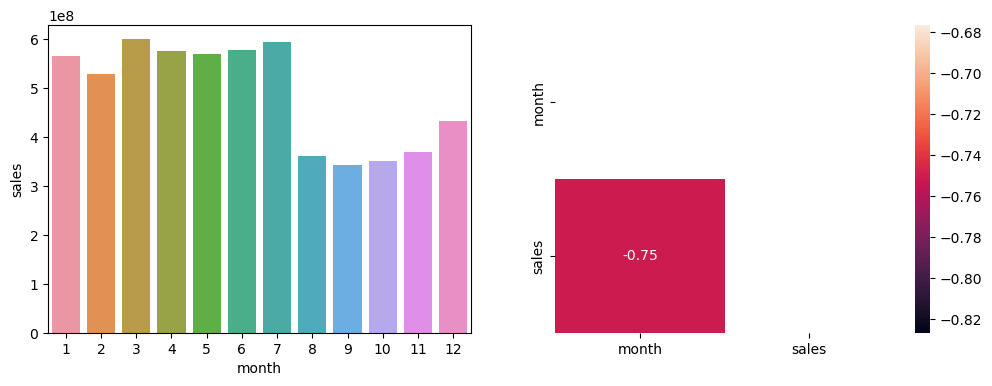

In [89]:
aux1 = df4[["sales", "month"]].groupby("month").sum().reset_index()

plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
sns.barplot(x="month", y="sales", data=aux1)

mask = np.zeros_like(aux1.corr(method="pearson"), dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method="pearson"), mask = mask, annot=True);

**False**

- Stores have lower sales in the second semester of the year.
- Pearson coefficient equals to -0.74 is a good correlation that means: the higher the month, the lower the sales.

#### H9. Stores should have higher sales after day 10 for every month.

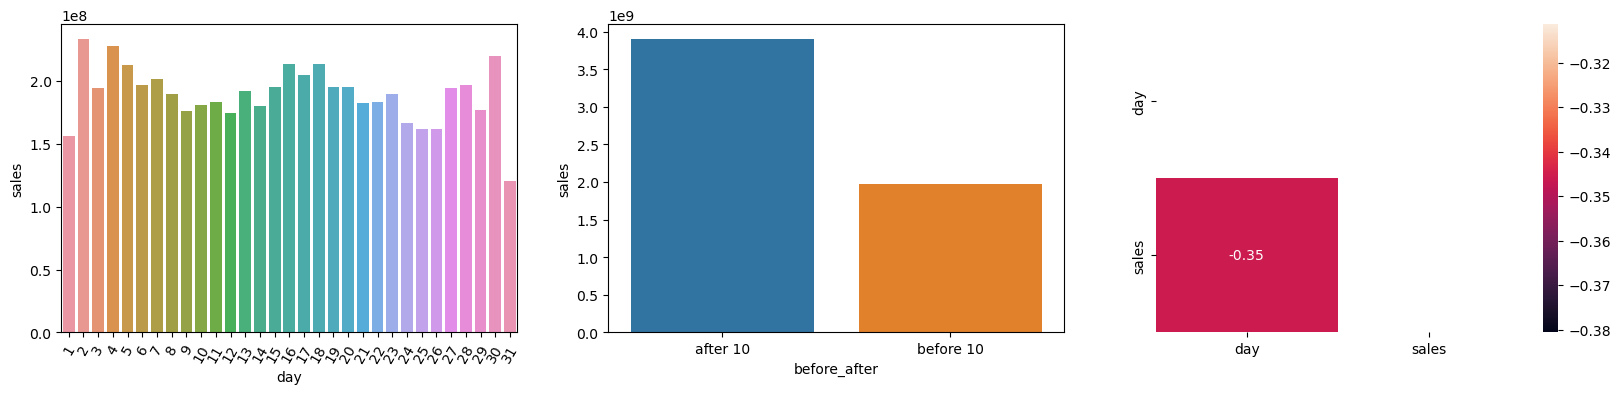

In [90]:
aux1 = df4[["sales", "day"]].groupby("day").sum().reset_index()

plt.figure(figsize = (20,4))

plt.subplot(1,3,1)
sns.barplot(x="day", y="sales", data=aux1)
plt.xticks(rotation=60);

aux1["before_after"] = aux1["day"].apply(lambda x: "before 10" if x <= 10 else "after 10")
aux2 = aux1[["sales", "before_after"]].groupby("before_after").sum().reset_index()

plt.subplot(1,3,2)
sns.barplot(x="before_after", y="sales", data=aux2)

mask = np.zeros_like(aux1.corr(method="pearson"), dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method="pearson"), mask = mask, annot=True);

**True**

- Stores have higher sales after day 10.
- They have higher sales after day 10, but probably because there are more days after day 10. 
- Pearson correlation coefficient is -0.35 (weak correlation). That means the higher the day, the lower the sales. 

#### H10. Stores should have lower sales on weekends.

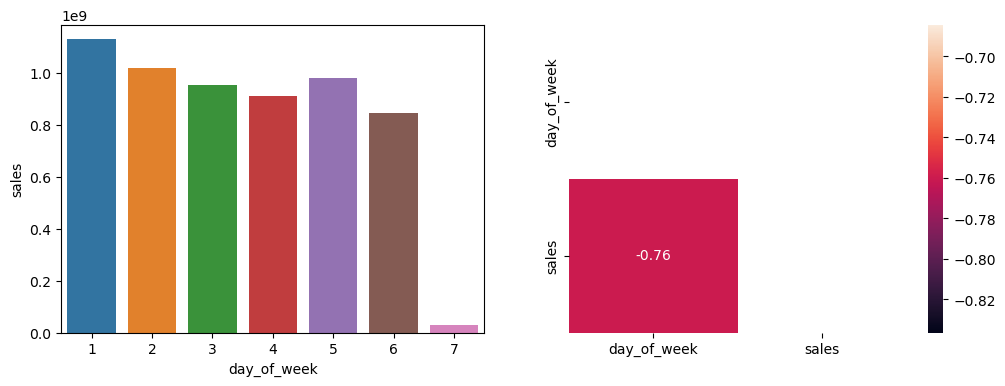

In [91]:
aux1 = df4[["sales", "day_of_week"]].groupby("day_of_week").sum().reset_index()

plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
sns.barplot(x="day_of_week", y="sales", data=aux1)

mask = np.zeros_like(aux1.corr(method="pearson"), dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method="pearson"), mask = mask, annot=True);

**True**

- They have lower sales on weekends.
- Pearson correlation coefficient is -0.76. That means a good negative correlation: the higher the days during the week, the lower the sales. 

#### H11. Stores should have lower sales on school holidays.

<AxesSubplot:xlabel='month', ylabel='sales'>

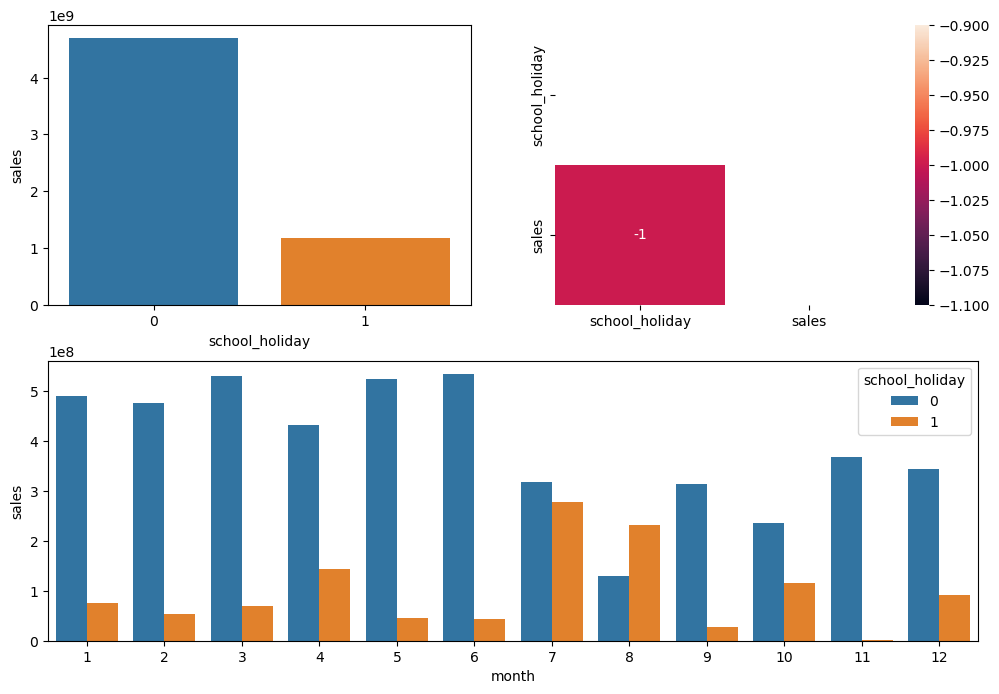

In [92]:
aux1 = df4[["school_holiday", "sales"]].groupby("school_holiday").sum().reset_index()

grid = gridspec.GridSpec(2, 2)

plt.figure(figsize = (12,8))

plt.subplot(grid[0,0])
sns.barplot(x="school_holiday", y="sales", data=aux1)

mask = np.zeros_like(aux1.corr(method="pearson"), dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.subplot(grid[0,1])
sns.heatmap(aux1.corr(method="pearson"), mask = mask, annot=True);

aux2 = df4[["month", "school_holiday", "sales"]].groupby(["month", "school_holiday"]).sum().reset_index()

plt.subplot(grid[1,:])
sns.barplot(x="month", y="sales", hue="school_holiday", data=aux2)

**True**

- Stores have lower sales during school holidays.
- Pearson coefficient of -1 means an extreme negative correlation. The less school holidays, the higher the sales.
- Since the data is from Europe, and over there school holidays are between July and August, these months have higher sales. In August, sales on school holidays are even higher than out of holidays. (maybe there are more school holidays in August)

### 4.2.1 Hypotheses findings

In [93]:
tab =[['Hypothesis', 'Conclusion', 'Relevance'],
      ['H1', 'False', 'Low'],  
      ['H2', 'False', 'Low'],  
      ['H3', 'False', 'Medium'],
      ['H4', 'False', 'High'],
      ['H5', 'False', 'High'],
      ['H6', 'False', 'Low'],
      ['H7', 'False', 'High'],
      ['H8', 'False', 'High'],
      ['H9', 'True', 'Low'],
      ['H10', 'True', 'High'],
      ['H11', 'True', 'High'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Low
H3            False         Medium
H4            False         High
H5            False         High
H6            False         Low
H7            False         High
H8            False         High
H9            True          Low
H10           True          High
H11           True          High


## 4.3. Multivariate Analysis

This analysis aims for evaluate the correlation between the features in order to exclude columns which are highly correlated. 

### 4.3.1. Numerical attributes

To analyze the correlation between numerical variables, we may use Pearson method. We cannot use this method to analyze categorical variables.

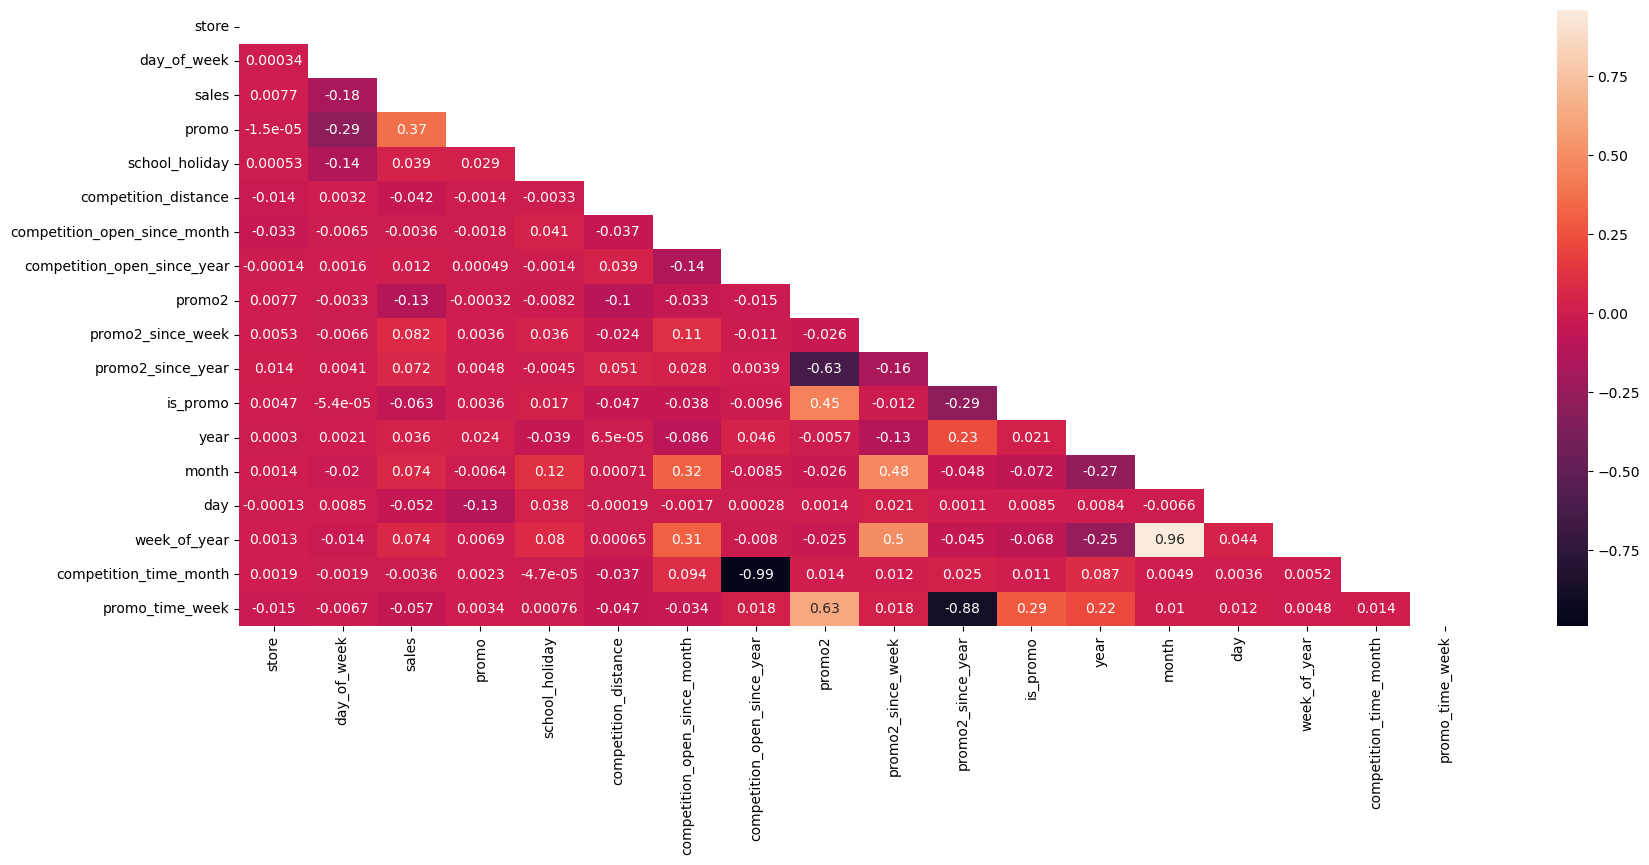

In [94]:
plt.figure(figsize = (20,8))

mask = np.zeros_like(num_attributes.corr(method="pearson"), dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(num_attributes.corr(method="pearson"), mask = mask, annot=True);

The top 3 numerical attributes most correlated with sales are:

1. promo: 0.37.
2. day_of_week: -0.18. 
3. promo2: -0.13. 

The top 5 most correlated features are:
    
1. competition_time_month and competition_open_since_year: -0.99. 
2. month and week_of_year: 0.96.
3. promo_time_week and promo2_since_year: -0.88. 
4. promo2_since_year and promo2: -0.63.
5. promo_time_week and promo2: 0.63. 

### 4.3.2. Categorical attributes

To analyze categorical variables we use the method Cramer's V. This method's range is 0 to 1. The cramer_v() function was declared in the previous section Helper Functions. 

In [95]:
cat_attributes.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


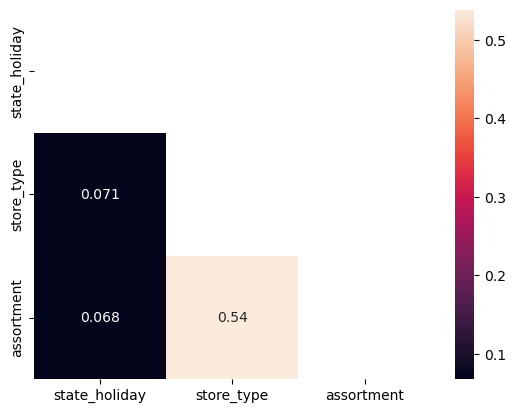

In [96]:
# Calculate cramer V
a1 = cramer_v( cat_attributes['state_holiday'], cat_attributes['state_holiday'] )
a2 = cramer_v( cat_attributes['state_holiday'], cat_attributes['store_type'] )
a3 = cramer_v( cat_attributes['state_holiday'], cat_attributes['assortment'] )

a4 = cramer_v( cat_attributes['store_type'], cat_attributes['state_holiday'] )
a5 = cramer_v( cat_attributes['store_type'], cat_attributes['store_type'] )
a6 = cramer_v( cat_attributes['store_type'], cat_attributes['assortment'] )

a7 = cramer_v( cat_attributes['assortment'], cat_attributes['state_holiday'] )
a8 = cramer_v( cat_attributes['assortment'], cat_attributes['store_type'] )
a9 = cramer_v( cat_attributes['assortment'], cat_attributes['assortment'] )

# Final correlation dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
                   'store_type':    [a4, a5, a6],
                   'assortment':    [a7, a8, a9]  
                  })
d = d.set_index( d.columns )

mask = np.zeros_like(d, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(d, mask = mask, annot=True);

- The most correlated features are assortment and store_type: 0.54. 
- The other features presented very weak correlation.

# 5. Data Preparation 

Machine Learning models works better with (1) numerical data (2) in the same scale. 

1. Normalization: to put every feature in the same scale. Rescale the center into zero with standard deviation equals to 1, that's it: range between -1 and 1. It helps to reduce higher importances between variables. It is proper for Gaussian/Normal distributions. 
2. Rescaling: rescale to the interval 0 to 1. It is proper to not Gaussian distributions (Gaussian = Normal). 
3. Transformation: transformation of categorical data into numerical (encoding), response variable transformation, and cyclical nature transformation (eg: 12 months into a cyclical learning). 

In [97]:
df5 = df4.copy()

## 5.1. Normalization

We may only apply normalization on features which follows Gaussian distribution (normal distribution). Looking at section 4.1.2, no feature presented a Gaussian distribution. The closest to a normal distribution is the target: sales. We are going to evaluate the normality with Shapiro-Wilk test and QQ-plot. 

### 5.1.1. Shapiro-Wilk test

The null hypothesis indicates that the data come from a normal distribution. If *p-value > alpha*, then it is a normal distribution.

In [98]:
alpha, p_value = ss.shapiro(df5["sales"])

print("alpha: " +  str(alpha))
print("p-value: " + str(p_value)) #since N > 5000, p-value is not accurate

alpha: 0.9019787311553955
p-value: 0.0


/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Since N > 5000, *p-value* is not accurate. Yet, it is still lower than *alpha*. That means our data do not come from a normal distribution.

### 5.1.2. QQ-plot

This is a statistical method to check the normality of data. QQ represents quantile quantile plot. If our data is normal, the plot will be a straight line. 

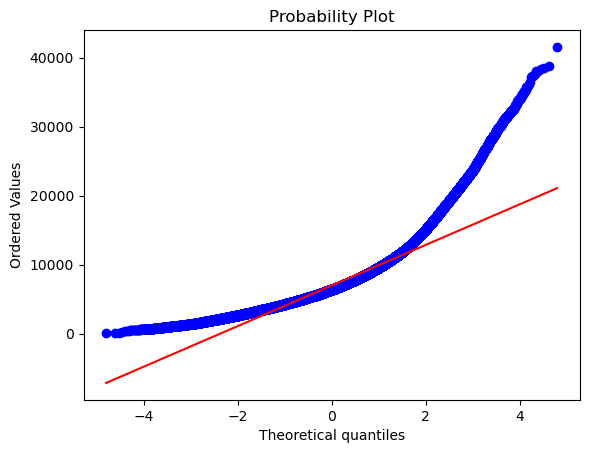

In [99]:
target = df5["sales"]  
ss.probplot(target, dist="norm", plot=pylab)
pylab.show()

Our data (blue points) deviates from a straight line. That means our data is not a normal distribution.

## 5.2. Rescaling

Here we are going to use **Min-Max Scaler**. This method does not modify the shape of the distribution, only the scale. An advantage is that Min-Max is very sensitive for outliers, since its formulae uses minimum and maximum points (range).

Instead of using minimum and maximum values from our dataset, we may use the first and the third quartiles (IQR - inter quartile range), used in boxplot. This technique is called **Robust Scaler** and we are goint to use it too. As it does not use maximum and minimum values, the distribution final shape is shortened. 

The main idea is to apply Min-Max Scaler to data without strong outliers and Robust Scaler to them with outliers.

In [100]:
num_attributes = df5.select_dtypes(include=["int64", "float64"])

In [101]:
num_attributes.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263.0,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064.0,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,65
2,3,5,8314.0,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,52
3,4,5,13995.0,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822.0,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


Let's select features with a broader range (keep those in 0-1 scale) and also exclude the ones which may be represented by another field. Then, let's check the outliers for these features in order to choose Min-Max or Robust scaler methods.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/si

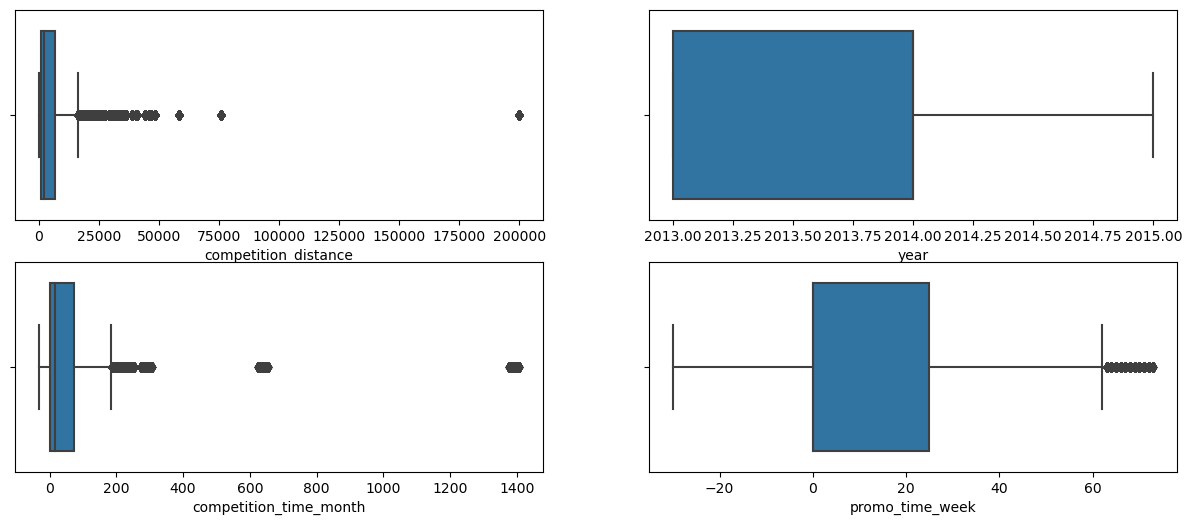

In [102]:
plt.figure(figsize = (15,6))

plt.subplot(2,2,1)
sns.boxplot(df5["competition_distance"])

plt.subplot(2,2,2)
sns.boxplot(df5["year"])

plt.subplot(2,2,3)
sns.boxplot(df5["competition_time_month"])

plt.subplot(2,2,4)
sns.boxplot(df5["promo_time_week"]);

- **competition_distance:** several outliers. 
- **year:** no outliers.
- **competition_time_month:** several outliers.
- **promo_time_week:** few outliers. 

In [103]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5["competition_distance"] = rs.fit_transform(df5[["competition_distance"]].values)

# year
df5["year"] = mms.fit_transform(df5[["year"]].values)

# competition_time_month
df5["competition_time_month"] = rs.fit_transform(df5[["competition_time_month"]].values)

# promo_time_week
df5["promo_time_week"] = mms.fit_transform(df5[["promo_time_week"]].values)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

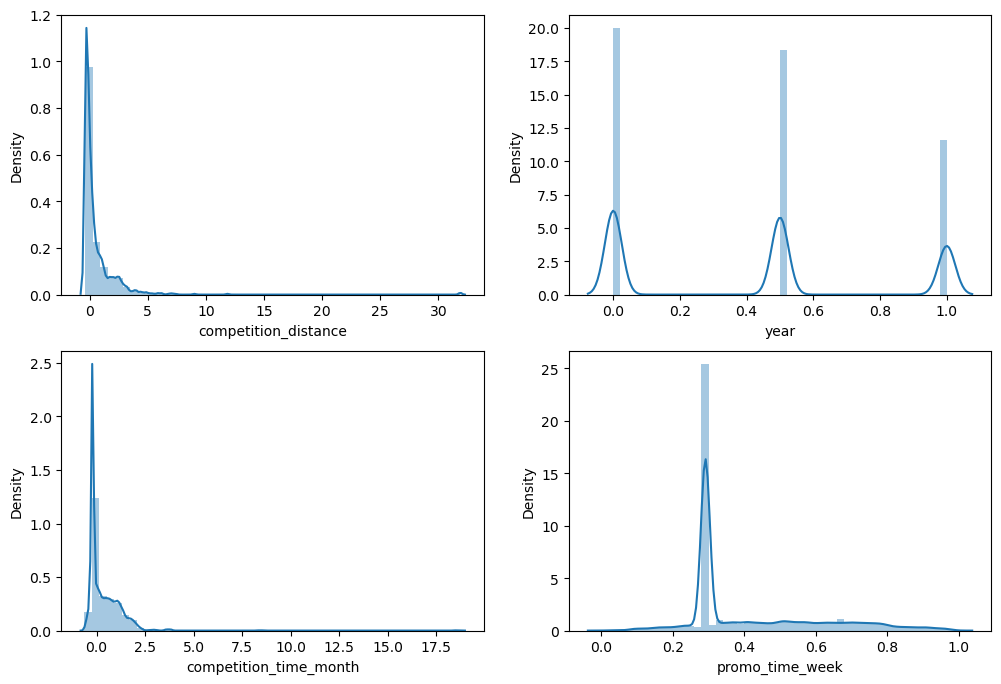

In [104]:
plt.figure(figsize = (12,8))

plt.subplot(2,2,1)
sns.distplot(df5["competition_distance"])

plt.subplot(2,2,2)
sns.distplot(df5["year"])

plt.subplot(2,2,3)
sns.distplot(df5["competition_time_month"])

plt.subplot(2,2,4)
sns.distplot(df5["promo_time_week"]);

## 5.3. Transformation

As we saw above, there are two types of transformation: encoding and cyclical nature.

### 5.3.1. Encoding

Types of encoding:

1. One Hot Encoding/Dummy Encoding: very easy and fast to applicate, yet it generates a lot of columns in the dataset. This type works very well with variables of type holiday: regular_day, public_holiday, school_holiday, and so on. 
2. Label Encoding: this type works very well with variables of type names. For example, store name.
3. Ordinal Encoding: it works with a specific order. For instance: low, high and medium. 
4. Target Encoding: this is used in categorical variables with several level. For example: a dataset with a color_column that has more than 100 colors. 
5. Frequency Encoding: it workds very well to differentiate trademarkds in a column.  
6. Embedding Encoding: used for neural networks. 

In [105]:
cat_attributes.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [106]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=["state_holiday"], columns=["state_holiday"])

# store_type - Label Encoding
le = LabelEncoder()
df5["store_type"] = le.fit_transform(df5["store_type"])

# assortment - Ordinal Encoding
assortment_dict = {"basic": 0,
                   "extended": 1,
                   "extra": 2}

df5["assortment"] = df5["assortment"].map(assortment_dict)

### 5.3.2. Response variable transformation 

The objective of this transformation is to make the response variable closer to a normal distribution. The closer to a normal distribution, the higher the model accuracy. 

There are some types of transforming the response variable:

1. Logarithm transformation.
2. Box-Cox transformation.
3. Cube-Root transformation. 
4. Square-Root transformation.
5. Sine and Cosine transformation. 

In [107]:
df5["sales"] = np.log1p(df5["sales"])

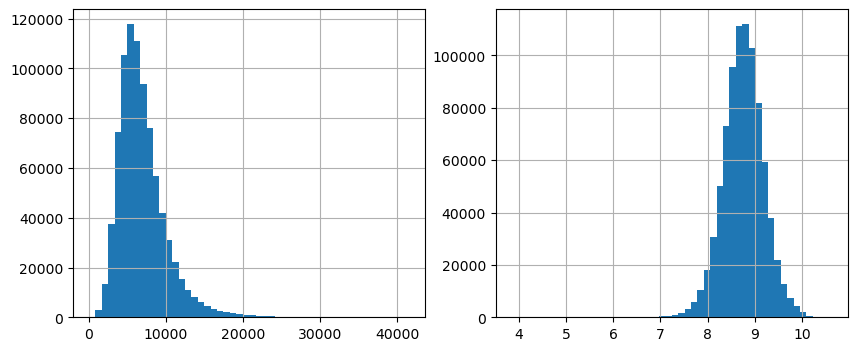

In [108]:
plt.figure(figsize = (10,4))

plt.subplot(1,2,1)
df4["sales"].hist(bins=50)

plt.subplot(1,2,2)
df5["sales"].hist(bins=50);

### 5.3.3. Cyclical nature transformation

The objective of this transformation is to be closer to the real nature in our dataset. For instance, on a linear scale, January (1) is far from December (12). On a clyclical scale, they are side by side - but in different years. 

In [109]:
# month
df5["month_sin"] = df5["month"].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5["month_cos"] = df5["month"].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5["day_sin"] = df5["day"].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5["day_cos"] = df5["day"].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week_of_year
df5["week_of_year_sin"] = df5["week_of_year"].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5["week_of_year_cos"] = df5["week_of_year"].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# day_of_week
df5["day_of_week_sin"] = df5["day_of_week"].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5["day_of_week_cos"] = df5["day_of_week"].apply(lambda x: np.cos(x * (2. * np.pi/7)))

In [110]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,0,-0.170968,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,0,-0.283871,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,0,1.903226,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,1,-0.275806,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,0,4.448387,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6. Feature Selection

The main motivation of this section is to identify and remove collinear variables to make a model the simplest as possible. Collinear variables are the ones that explains the same phenomenon. 

In [111]:
df6 = df5.copy()

There are three types of feature selection:

1. Univariate selection (Filter Methods): this selection is made by relevance. We may apply Pearson correlation to identify the most correlated features with the sales.
2. Selection by importance (Embedded Methods): Random Forest, Lasso Regression and Ridge Regression. These algorithms attribute different weights for every variable.   
3. Selection by subset (Wrapper Methods): Boruta Algorithm.

The choice depends on the type of the variable:

1. If the responsible variable is continuous and the features are also continuous: Pearson Correlation.
2. If the responsible variable is continuous and the features are categorical: ANOVA.
3. If the responsible variable is categorical and the features are continuous: Linear Discriminant Analysis (LDA).
4. If the responsible variable is categorical and the features are categorical: Cramer's V. 

## 6.1. Split dataframe into training and test dataset

In [112]:
df6.sample(4).T

,742381,244326,607361,161150
store,577,558,472,591
day_of_week,3,2,5,1
date,2013-09-04 00:00:00,2014-12-23 00:00:00,2014-01-03 00:00:00,2015-03-09 00:00:00
sales,8.357259,8.536407,8.469053,8.65904
promo,0,0,0,0
school_holiday,0,1,1,0
store_type,0,0,2,0
assortment,1,0,1,1
competition_distance,-0.009677,0.108065,0.435484,0.162903
competition_open_since_month,9,2,8,3


First, let's delete (1) the original columns that are repeated and (2) the date fields. The fields date and sales we must delete too, but we will do it later. 

In [113]:
cols_drop = ["week_of_year", "day_of_week", "day", "month", "promo_since", "competition_since", "year_week"]
df6 = df6.drop(cols_drop, axis=1)

To train and test the model, we must split the dataset into different dates. If we train the model with a dataset that contains dates from the same period of the test dataset, the model will not learn properly how to make a prediction.

Thus, we are going to separate our dataframe into two datesets: (1) test: data from the last 6 weeks we have in the dataset and (2) training: all data before the period selected for test. 

Let's identify the minimum and the maximum date from our dataframe. 

In [114]:
df6[["date", "store"]].groupby("store").min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [115]:
df6[["date", "store"]].groupby("store").max().reset_index()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
...,...,...
1110,1111,2015-07-31
1111,1112,2015-07-31
1112,1113,2015-07-31
1113,1114,2015-07-31


The maximum and the minimum date for every store is, respectively: 2013-01-02 and 2015-07-31. Let's subtract 6 weeks from the maximum date:

In [116]:
df6[["date", "store"]].groupby("store").max().reset_index()["date"][0] - timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

Therefore, dates before 2015-06-19 will be for the training dataset and after this date will be for the test dataset.

In [117]:
# training dataset
x_train = df6[df6["date"] < "2015-06-19"]
y_train = x_train["sales"]

# test dataset
x_test = df6[df6["date"] >= "2015-06-19"]
y_test = x_test["sales"]

print("Min date for training: {}".format(x_train["date"].min()))
print("Max date for training: {}".format(x_train["date"].max()))

print("\nMin date for test: {}".format(x_test["date"].min()))
print("Max date for test: {}".format(x_test["date"].max()))

Min date for training: 2013-01-01 00:00:00
Max date for training: 2015-06-18 00:00:00

Min date for test: 2015-06-19 00:00:00
Max date for test: 2015-07-31 00:00:00


## 6.2. Boruta as feature selector

In [118]:
# excluding columns and creating training and test vectors for Boruta
#x_train_n = x_train.drop(columns=["sales", "date"], axis=1).values
#y_train_n = y_train.values.ravel()

# define Random Forest Regressor
#rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
#boruta = BorutaPy(rf, n_estimators="auto", verbose=2, random_state=42).fit(x_train_n, y_train_n)

### 6.2.1. Best features from Boruta

In [119]:
#cols_selected = boruta.support_.tolist()

# best features selected for Boruta
#x_train_fs = x_train.drop(["sales", "date"], axis=1)
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list() 

# features not selected for Boruta
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

In [120]:
#cols_selected_boruta

In [121]:
#cols_not_selected_boruta

## 6.3. Manual feature selection

Since boruta takes too much time to run, we saved manually the columns selected previously by boruta. When boruta excluded some trigonometric function from a pair, but included one of a pair, we included manually the feature which was excluded. We also included manually the features sales and date. 

In [122]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'month_sin',                       
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',                       
     'week_of_year_cos',
     'day_of_week_sin',
     'day_of_week_cos'
]

# columns to add
feat_to_add = ["sales", "date"]

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [123]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# 7. Machine Learning Modelling

The main objective of a machine learning model, to this project, is to learn the sales behavior with the available attributes in order to use it in a general manner in the future.

There are three types of tasks that a Machine Learning algorithm takes:

1. Supervised task: the goal is to learn patterns from what we have in our dataset and then make predictions based on what we have said to the model. **Classification, regression, prediction and time series** are examples of supervised task. E.g.: vehicle prices prediction based on vehicles dimensions and names. 
2. Unsupervised task: the main goal is to make groups from our data based on characteristics and patterns the model found by itself - whithout something said previously. E.g.: grouping fruits or animals based on the attributes we have in our dataset. This type of task is called **clustering**.
3. Semi-supervised task: this type does not have a dataset, it learns during the execution. It is based on action and reward. The actions are performed by an agent over an environment - which returns a reward. Initially, the model returns two types of rewards: negative and positive. After a while, the model learns how to return only positive rewards. E.g.: to identify the optimum creative performance based on clicks made by users. This type of task is called **reinforcement learning**. It is similar to A/B testing, but it has an advantage because we do not separate different populations to do the analysis. 

The core difference between the two types of task is that supervised is when we have a right answer and want a prediction (we know very well something and want a prediction), while unsupervised we do not have a right answer and we want to group our data (we do not know anything and want to learn about it). 

Types of Machine Learning models:
    
1. Average Model.
2. Linear Regression.
3. Linear Regression Regularized. 
4. Random Forest Regressor.
5. XGBoost Regressor. 

In [127]:
# training dataset - X_train in UPPERCASE contains all data
X_train = df6[df6["date"] < "2015-06-19"]
y_train = X_train["sales"]

# test dataset - X_test in UPPERCASE contains all data
X_test = df6[df6["date"] >= "2015-06-19"]
y_test = X_test["sales"]

In [128]:
# x_train and x_test in LOWERCASE contains filtered data
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [129]:
aux1 = x_test.copy()
aux1["sales"] = y_test.copy()

# prediction
aux2 = aux1[["store", "sales"]].groupby("store").mean().reset_index().rename(columns={"sales": "predictions"})
aux1 = pd.merge(aux1, aux2, how="left", on="store")
yhat_baseline = aux1["predictions"]

# performance
baseline_result = ml_error("Average Model", np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression 

In [130]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error("Linear Regression", np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1861.250248,0.291652,2662.572303


- RMSE from linear regression is higher than the average model's. 
- Average model is better to predict sales than linear regression.
- Probably, our data is complex and a linear regression does not represent our data. 

### 7.2.1. Linear Regression - Cross-Validation

In [131]:
lr_result_cv = cross_validation(x_training, 5, "Linear Regression", lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2077.84 +/- 296.13,0.3 +/- 0.02,2945.75 +/- 469.28


## 7.3. Linear Regression Regularized - Lasso

Lasso Regression may brings a linear result by making coefficients - of features more irrelevant - closer to zero. The function Lasso() makes it automatically, we just need to choose a value for alpha.

We can reduce alpha value in order to find a minor error. Yet, it was tested and minor values than 0.001 did not result in much better results and was very time-consuming. 

In [132]:
# model
lrr = Lasso(alpha=0.001).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error("Linear Regression - Lasso", np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1864.159557,0.287184,2686.040377


This result means the phenomenon is not linear. It is a complex phenomenon and we must to fit non-linear models.

- RMSE for Lasso is higher than for linear regression.
- Our data is a complex phenomenon. 

### 7.3.1. Lasso - Cross-Validation

In [133]:
lrr_result_cv = cross_validation(x_training, 5, "Linear Regression Regularized - Lasso", lrr, verbose=False)
lrr_result_cv

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e+03, tolerance: 1.194e+01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.529e+01, tolerance: 1.257e+01
  model = cd_fast.enet_coordinate_descent(


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Regularized - Lasso,2085.5 +/- 327.35,0.29 +/- 0.01,2982.37 +/- 500.44


## 7.4. Random Forest Regression

In [134]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error("Random Forest Regression", np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regression,681.813536,0.100196,1016.569703


- This fit is a way better than the others so far.
- Here are the minor error values. 

### 7.4.1. Random Forest Regression - Cross-Validation 

In [135]:
rf_result_cv = cross_validation(x_training, 5, "Random Forest Regression", rf)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regression,846.02 +/- 215.0,0.12 +/- 0.02,1274.53 +/- 315.17


## 7.5. XGBoost Regression

In [136]:
# model
model_xgb = xgb.XGBRegressor(objective="reg:squarederror", 
                         n_estimators=100, 
                         eta=0.01,
                         max_depth=10,
                         sub_sample=0.7,
                         colsample_bytee=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error("XGBoost Regression", np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[15:06:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytee", "sub_sample" } are not used.



,Model Name,MAE,MAPE,RMSE
0,XGBoost Regression,6683.542364,0.949523,7330.483391


### 7.5.1. XGBoost Regression - Cross-Validation 

In [137]:
xgb_result_cv = cross_validation(x_training, 5, "XGBoost Regression", model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5
[15:06:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytee", "sub_sample" } are not used.


KFold Number: 4
[15:07:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytee", "sub_sample" } are not used.


KFold Number: 3
[15:07:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytee", "sub_sample" } are not used.


KFold Number: 2
[15:08:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytee", "sub_sample" } are not used.


KFold Number: 1
[15:08:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpy

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regression,7047.87 +/- 587.34,0.95 +/- 0.0,7713.5 +/- 688.29


## 7.6. Models Performance Comparison

### 7.6.1 Single Performance (K-Fold = 1)

In [138]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values("RMSE")

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regression,681.813536,0.100196,1016.569703
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1861.250248,0.291652,2662.572303
0,Linear Regression - Lasso,1864.159557,0.287184,2686.040377
0,XGBoost Regression,6683.542364,0.949523,7330.483391


The phenomenon we are trying to model is a complex one. That's why we see better fit for Random Forest than for linear regressions, based on RMSE. In the next section we will apply Cross-Validation in order to evaluate the real models performance.

### 7.6.1. Real Performance - Cross-Validation (K-Fold = 5)

To evaluate the real performance, we trained the model in several periods of time (multiples of 6 weeks: k * 6 * 7), not only for the last 6 weeks as we have done before. This technique of splitting our dataset in many parts in order to measure its performance is called **Cross-Validation**. The motivation of doing this is because if we select only one period of time and for this period there is little or none variability, our model will perform very well and we will have minor erros. However, it is not the real performance.

We performed the Cross-Validation in a subsection for every model above. The Cross-Validation function and all statistical measure are in the beginning of this notebook in the section named Helper Functions. The results of average errors and their standard deviation for each Machine Learning model may be seen in the table below.

We have two types of Cross-Validation application:

1. Regression or Classification.
2. Time series. 

They are different because for the first type the split is made randomly, while for the second is made accordingly to the data chronological order. We performed the Cross-Validation applied to time series.

In [139]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2077.84 +/- 296.13,0.3 +/- 0.02,2945.75 +/- 469.28
0,Linear Regression Regularized - Lasso,2085.5 +/- 327.35,0.29 +/- 0.01,2982.37 +/- 500.44
0,Random Forest Regression,846.02 +/- 215.0,0.12 +/- 0.02,1274.53 +/- 315.17
0,XGBoost Regression,7047.87 +/- 587.34,0.95 +/- 0.0,7713.5 +/- 688.29


# 8. Hyperparameter Fine Tuning